# 3D Protein Pose Recovery - Robustness to Unseen Protein

Through the following model, we consider that a cryo-EM measurement (i.e. 2D projection) $\mathbf{y}_i \in \mathbb{R}^{M}$ is acquired through
\begin{equation}
\label{eq:linear-forward-model}
\mathbf{y}_i={\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x+\mathbf n,
\end{equation}
where $\mathbf x \in \mathbb{R}^{V}$ is the unknown 3D density map [*DiMaio et al.*](https://academic.oup.com/bioinformatics/article/23/21/2851/374177) (Coulomb potential). The operator $\mathbf P_{\theta_i}: \mathbb R^V \to \mathbb R^M$ is the projection along the 3D pose $\theta_i$ (i.e., the x-ray transform). The operator $\mathbf S_\mathbf{t}: \mathbb R^M \to \mathbb R^M$ is a shift of the projection by $\mathbf{t}=(t_1, t_2)$. The convolution operator $\mathbf {C}_{\boldsymbol\varphi}: \mathbb R^M \to \mathbb R^M$ models the microscope contrast transfer function (CTF) with parameters $\boldsymbol\varphi=(d_1, d_2, \alpha_{\rm ast})$, that are, respectively, the defocus-major, the defocus-minor and the angle of astigmatism. Finally, $\mathbf n \in \mathbb{R}^{M}$ represents an additive noise. Our goal is then to recover the angles $\theta_i$ from every projection $\mathbf y_i$. 

Final **goal**: We have $N$ protein 3D volumes that are used to create the training set of 2D projections $\{\mathbf y_{N, i}^{train}\}$. Another, unseen protein 3D volume $\mathbf x^{test}$ is used to create the test set of 2D projections $\{\mathbf y_i^{test}\}$. The set of projections is created using the projection $\mathbf P_{\theta_i}$ along the 3D pose $\theta_i$ as well as all the other operators (noise $\mathbf n$, CTF $\mathbf C_\varphi$, shift $\mathbf S_{\mathbf t}$) specified in the equation above. 


  $\{\mathbf x_1^{train}, ..., \mathbf x_N^{train}\}  \rightarrow \{\mathbf y_{N, i}^{train}\} = \{{\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x_N^{train}+\mathbf n\}$
  

  $\mathbf x^{test} \rightarrow \{\mathbf y_i^{test}\} =\{{\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x^{test}+\mathbf n\}$

[Only one - 5j0n](http://0.0.0.0:8080/notebooks/notebooks/1-phase1/limited3.14_angle_recovery_with_estimated_distances.ipynb)

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import sys
sys.path.append("..") 
from cryoem.projections import generate_2D_projections
from cryoem.plots import plot_projection, plot_detector_pixels, plot_angles_count
from cryoem.preprocessing import preprocessing, train_val_test_split
from cryoem.distance_estimation import train_distance_estimation
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl, Adam
from cryoem.conversions import quaternion2euler
import matplotlib.pyplot as plt
from cryoem.conversions import d_q, euler2quaternion
from cryoem.reconstruction import reconstruct
from cryoem.plots import plot_dP_dQ
import h5py
import ipyvolume as ipv
import numpy as np
import pathlib
import tensorflow as tf
from tensorflow.python.client import device_lib 
# from numba import cuda
tf.__version__

'2.0.0'

In [3]:
!echo $CUDA_VISIBLE_DEVICES

0


In [4]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1846186061039702704
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3475675535934856030
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1601596894323743465
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3869638656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8199281595969627988
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
!which python

/home/jelena/miniconda3/envs/protein_reconstruction/bin/python


## (1) Generate Sythetic Data

In [6]:
MRC_DIR         = "/home/jelena/MRC"  #"/mnt/scratch/students/MRC"
RESULTS_DIR     = "/home/jelena/data"  #"/mnt/scratch/students"
pathlib.Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

#### Asymmetric proteins - C1

In [7]:
############
NUM_TRAIN_PROTEINS = 4
NUM_TEST_PROTEINS  = 1

PROTEINS  = [#'4usn.mrc', 
             '5nvu.mrc',
             '5nvs.mrc',
             '6mem.mrc',
             '6o1o.mrc',
             '5j0n.mrc',
             #'6o1o.mrc',
             #'6ran.mrc',
             #'6ram.mrc',
             ]
# PROTEINS = ['5j0n.mrc', 
#             '5j0n.mrc',
#             '5j0n.mrc',
#             '5j0n.mrc',
#             '5j0n.mrc']
PROTEINS = list(map(lambda x: x[:-4], PROTEINS))

PROTEINS_TRAIN = PROTEINS[:NUM_TRAIN_PROTEINS]
PROTEINS_TEST  = PROTEINS[NUM_TRAIN_PROTEINS:NUM_TRAIN_PROTEINS+NUM_TEST_PROTEINS]

In [8]:
# 2.0, 1.0, 1.0 - 1/2 - 5j0n
# 2.0, 0.5, 1.0 - 1/2
# 2.0, 0.4, 2.0 - used when one

# 2.0, 1.0, 2.0 - 1
# 2.0, 1.0, 0.5 - 1/4 - 5a1a

In [9]:
PROJECTIONS_NUM_SINGLE = 1000
# ang1, ang2, ang3(=inplane rotation)
ANGLE_COVERAGE  = [2.0, 0.4, 2.0]
ANGLE_SHIFT     = [0., 0., 0.]

In [10]:
IMG_DIM = 64
NOISE_VAR_SCALE = 0   # it takes max px value to be the variance, since all proteins have it different
TRANSLATION = 0
CHANNELS = 1
DTYPE = np.float16

In [11]:
# generate sythetic data - 2D projections and their corresponding orientations from a given 3D protein
for protein in PROTEINS_TRAIN + PROTEINS_TEST: 
    generate_2D_projections(input_file_path=f"{MRC_DIR}/{protein}.mrc", 
                            ProjNber=PROJECTIONS_NUM_SINGLE,
                            AngCoverage=ANGLE_COVERAGE,
                            AngShift=ANGLE_SHIFT,
                            Angles=None, #np.load(f"{RESULTS_DIR}/custom_true_angles.npy"), #np.load(f"{RESULTS_DIR}/custom_true_angles.npy"),
                            angles_gen_mode="uniform_angles",#"uniform_angles",
                            output_file_name=f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5",  #f"{RESULTS_DIR}/{protein}_given.h5",  
                            dtype=DTYPE)
    #cuda.current_context().reset() 

* Loading the dataset *
Protein:         5nvu
Input filename:  /home/jelena/MRC/5nvu.mrc
Output filename: /home/jelena/data/5nvu_ProjectionsAngles_ProjNber1000_AngCoverage2.0,0.4,2.0_AngShift2.0,0.4,2.0.h5
Projections (#): (1000, 448, 448)
Angles (#):      (1000, 3)

**********
* Loading the dataset *
Protein:         5nvs
Input filename:  /home/jelena/MRC/5nvs.mrc
Output filename: /home/jelena/data/5nvs_ProjectionsAngles_ProjNber1000_AngCoverage2.0,0.4,2.0_AngShift2.0,0.4,2.0.h5
Projections (#): (1000, 271, 271)
Angles (#):      (1000, 3)

**********
* Loading the dataset *
Protein:         6mem
Input filename:  /home/jelena/MRC/6mem.mrc
Output filename: /home/jelena/data/6mem_ProjectionsAngles_ProjNber1000_AngCoverage2.0,0.4,2.0_AngShift2.0,0.4,2.0.h5
Projections (#): (1000, 229, 229)
Angles (#):      (1000, 3)

**********
* Loading the dataset *
Protein:         6o1o
Input filename:  /home/jelena/MRC/6o1o.mrc
Output filename: /home/jelena/data/6o1o_ProjectionsAngles_ProjNber1000_Ang

In [12]:
# # read stored data for further processing
# projections_train = []  #np.empty((len(PROTEINS_TRAIN)*PROJECTIONS_NUM_SINGLE, IMG_DIM, IMG_DIM, CHANNELS), dtype=DTYPE)
# angles_true_train = []  #np.empty((len(PROTEINS_TRAIN)*PROJECTIONS_NUM_SINGLE, 3), dtype=DTYPE)

# print(f"* Train dataset *")
# for i, protein in enumerate(PROTEINS_TRAIN):
#     data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
#     projections = np.array(data['Projections'])
#     angles_true = np.array(data['Angles'])
    
#     print(f"--- protein: {protein} ---")
#     print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
#     print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")

#     projections = preprocessing(projections, rescale_dim=IMG_DIM, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=CHANNELS)
   
#     projections_train.extend(projections)
#     angles_true_train.extend(angles_true)

# projections_test = []  #np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, IMG_DIM, IMG_DIM, CHANNELS), dtype=DTYPE)
# angles_true_test = []  #np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, 3), dtype=DTYPE)

# print(f"\n* Test dataset *")
# for i, protein in enumerate(PROTEINS_TEST):
#     data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
#     projections = np.array(data['Projections'])
#     angles_true = np.array(data['Angles'])
    
#     print(f"--- protein: {protein} ---")
#     print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
#     print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")
    
#     projections = preprocessing(projections, rescale_dim=IMG_DIM, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=CHANNELS)
    
#     projections_test.extend(projections)
#     angles_true_test.extend(angles_true)
    

In [13]:
# projections_train = np.array(projections_train).astype(DTYPE)
# angles_true_train = np.array(angles_true_train).astype(DTYPE)

# projections_test = np.array(projections_test).astype(DTYPE)
# angles_true_test = np.array(angles_true_test).astype(DTYPE)

In [14]:
#PROJECTIONS_NUM_SINGLE = 1000
# read stored data for further processing
projections_train = np.empty((len(PROTEINS_TRAIN)*PROJECTIONS_NUM_SINGLE, IMG_DIM, IMG_DIM, CHANNELS), dtype=DTYPE)
angles_true_train = np.empty((len(PROTEINS_TRAIN)*PROJECTIONS_NUM_SINGLE, 3), dtype=DTYPE)

print(f"* Train dataset *")
i = 0
while i < len(PROTEINS_TRAIN):
    protein = PROTEINS_TRAIN[i]
    print(f"--- protein: {protein} ---")
    
    data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
    #data = h5py.File(f"{RESULTS_DIR}/{protein}_given.h5", 'r')
    
    projections = np.array(data['Projections'], dtype=np.float32)
    if np.min(projections) - np.max(projections) == 0: 
        print("Data corrupted - projections")
        PROTEINS_TRAIN.remove(protein)
        continue
    angles_true = np.array(data['Angles'], dtype=np.float32)

    if np.isnan(angles_true).any(): 
        print("Data corrupted - angles")
        PROTEINS_TRAIN.remove(protein)
        continue
    
    
    print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
    print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")

    projections = preprocessing(projections, rescale_dim=IMG_DIM, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=CHANNELS)
   
    projections_train[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = projections.astype(DTYPE)
    angles_true_train[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = angles_true.astype(DTYPE)
    
    i += 1

#PROJECTIONS_NUM_SINGLE = 5000
projections_test = np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, IMG_DIM, IMG_DIM, CHANNELS), dtype=DTYPE)
angles_true_test = np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, 3), dtype=DTYPE)

print(f"\n* Test dataset *")
i = 0
while i < len(PROTEINS_TEST):
    protein = PROTEINS_TEST[i]
    print(f"--- protein: {protein} ---")
    
    data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
    #data = h5py.File(f"{RESULTS_DIR}/{protein}_given.h5", 'r')
    projections = np.array(data['Projections'], dtype=np.float32)
    if np.isnan(projections).any() or (np.min(projections) - np.max(projections) == 0): 
        print("Data corrupted - projections")
        PROTEINS_TEST.remove(protein)
        continue
    angles_true = np.array(data['Angles'], dtype=np.float32)

    if np.isnan(angles_true).any(): 
        print("Data corrupted - angles")
        PROTEINS_TEST.remove(protein)
        continue
    
    
    print(f"{projections_test.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
    print(f"{angles_true_test.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")
    
    projections = preprocessing(projections, rescale_dim=IMG_DIM, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=CHANNELS)
    
    projections_test[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = projections.astype(DTYPE)
    angles_true_test[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = angles_true.astype(DTYPE)
    
    i += 1

* Train dataset *
--- protein: 5nvu ---
1000 projections of images with dimension (448, 448) pixels
1000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images
Preprocessing projections
	Image rescaled: 
		from dimension 448 to 64
	Global standardization
		Image shape: (64, 64)
		Data Type: float64
		Mean: 0.366 | Std: 1.502
		Min:  0.000 | Max: 30.820
		Mean: -0.000 | Std: 1.000
		Min:  -0.244 | Max: 20.280
	Noise:
		No noise
	Translation:
		No translation
--- protein: 5nvs ---
1000 projections of images with dimension (271, 271) pixels
1000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images
Preprocessing projections
	Image rescaled: 
		from dimension 271 to 64
	Global standardization
		Image shape: (64, 64)
		Data Type: float64
		Mean: 0.390 | Std: 1.526
		Min:  0.000 | Max: 25.576
		Mean: 0.000 | Std: 1.000
		Min:  -0.255 | Max: 16.501
	Noise:
		No noise
	Translation:
		No translation
--- protein: 6mem ---
1000 proj

In [15]:
NUM_TRAIN_PROTEINS = len(PROTEINS_TRAIN)
NUM_TEST_PROTEINS  = len(PROTEINS_TEST)
print(PROTEINS_TRAIN)
print(PROTEINS_TEST)

['5nvu', '5nvs', '6mem', '6o1o']
['5j0n']


In [16]:
projections_test.shape

(1000, 64, 64, 1)

In [17]:
# plot_projection(np.squeeze(projections_test[1000]).astype(np.float32), angles=angles_true_test[0])

In [18]:
type(projections_train[0][0][0][0])

numpy.float16

In [19]:
from cryoem.plots import plot_detector_pixels, plot_rotvec

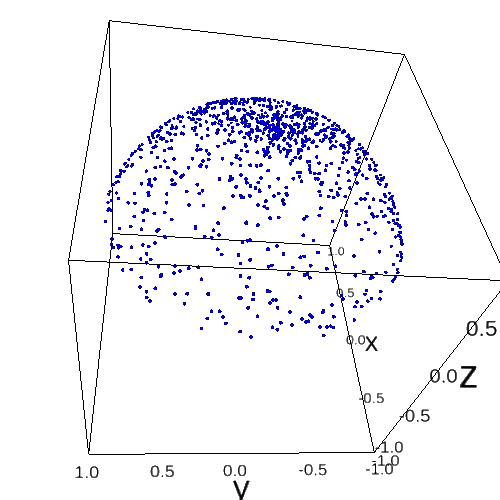

In [21]:
plot_detector_pixels(angles_true_test)

In [22]:
ipv.screenshot()

Output()

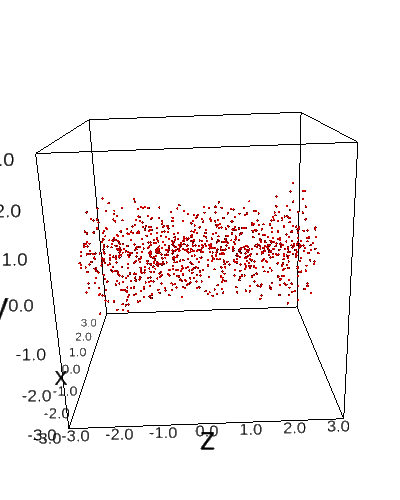

In [23]:
plot_rotvec(angles_true_test)

In [24]:
ipv.screenshot()

Output()

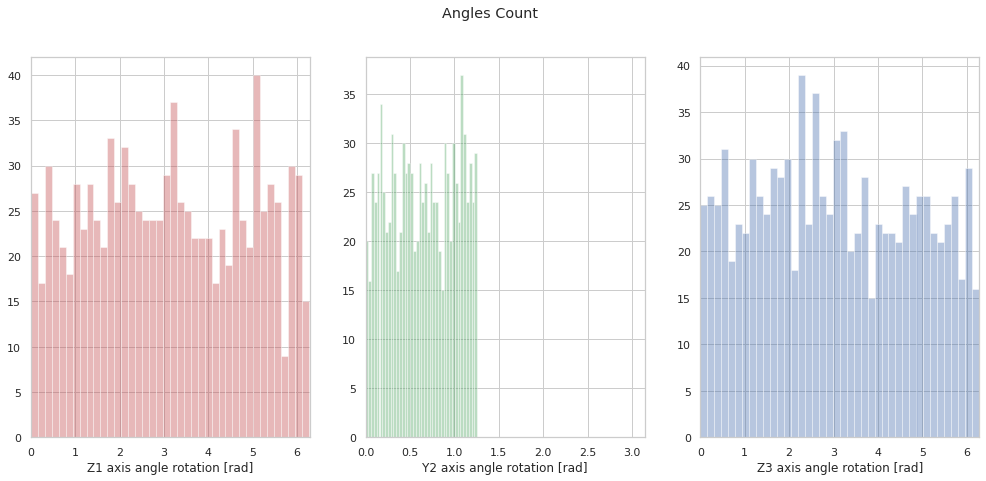

In [20]:
plot_angles_count(np.array(angles_true_test))

## (2) Distance Learning

In [18]:
PROJECTIONS_NUM = NUM_TRAIN_PROTEINS * PROJECTIONS_NUM_SINGLE
PROJECTIONS_NUM

4000

In [19]:
############
DE_LOGS_DIR = f"{RESULTS_DIR}/distance_estimation"
#DE_DESCRIPTION = "full_pipeline_5j0n"
DE_DESCRIPTION = "full_pipeline_unseen_proteins_given_projDir"

In [20]:
train_idx, val_idx, test_idx, train_pairs_num, val_pairs_num = train_val_test_split(PROJECTIONS_NUM, test_size=0.0001, val_size=0.35, train_percent=0.001, val_percent=0.001, indices_file="")

TRAIN: 1.00 x 0.65 = 0.65 =>  2599 imgs => max pairs:    6754801   |   6754
TEST :             0.0001 =>     1 imgs => max pairs:          1   |   all
VAL  : 1.00 x 0.35 = 0.35 =>  1400 imgs => max pairs:    1960000   |   1960
Indices stored in 


Data created in 3.153149366378784 sec
Data created in 0.8878426551818848 sec
Input images shape (64, 64, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
___________________________________________________________________________________

27/27 [==============================] - 21s 767ms/step - loss: 0.1830 - mse: 0.0551 - val_loss: 0.2986 - val_mse: 0.1531
Epoch 40/100
27/27 [==============================] - 22s 800ms/step - loss: 0.1854 - mse: 0.0570 - val_loss: 0.2969 - val_mse: 0.1485
Epoch 41/100
27/27 [==============================] - 23s 842ms/step - loss: 0.1807 - mse: 0.0547 - val_loss: 0.3008 - val_mse: 0.1497
Epoch 42/100
27/27 [==============================] - 23s 840ms/step - loss: 0.1725 - mse: 0.0502 - val_loss: 0.2973 - val_mse: 0.1491
Epoch 43/100
27/27 [==============================] - 20s 749ms/step - loss: 0.1757 - mse: 0.0511 - val_loss: 0.2836 - val_mse: 0.1358
Epoch 44/100
27/27 [==============================] - 21s 767ms/step - loss: 0.1695 - mse: 0.0485 - val_loss: 0.3103 - val_mse: 0.1690
Epoch 45/100
27/27 [==============================] - 23s 849ms/step - loss: 0.1713 - mse: 0.0493 - val_loss: 0.3039 - val_mse: 0.1556
Epoch 46/100
27/27 [==============================] - 22s 815ms/step

Epoch 100/100
27/27 [==============================] - 23s 849ms/step - loss: 0.0988 - mse: 0.0182 - val_loss: 0.2696 - val_mse: 0.1264


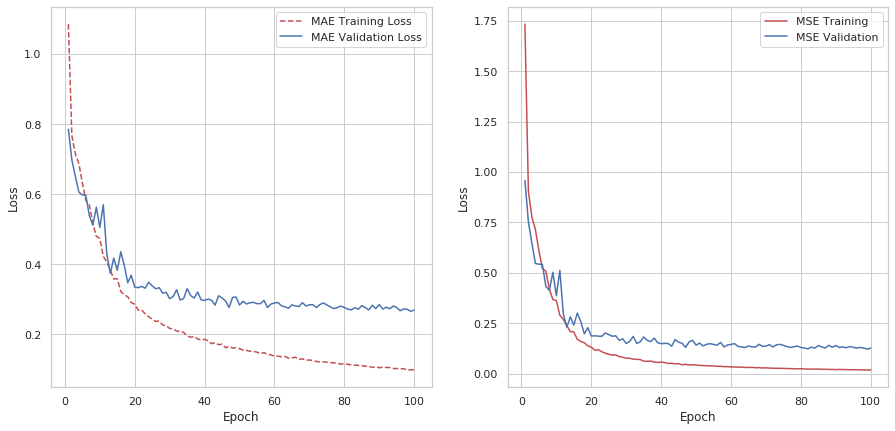

In [26]:
model, history = train_distance_estimation(X=projections_train, y=angles_true_train, 
                                           train_idx=train_idx, 
                                           val_idx=val_idx,
                                           epochs=100,
                                           batch_size=256,  #512 latest 
                                           learning_rate=1e-3, 
                                           limit_style="random", 
                                           path_logs_training=DE_LOGS_DIR, 
                                           training_description=DE_DESCRIPTION,
                                           training_steps=train_pairs_num,
                                           validation_steps=val_pairs_num, 
                                           plot=True,
                                           gpus=None)

In [21]:
# read stored model
model_filename = f"{DE_LOGS_DIR}/training/{DE_DESCRIPTION}.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [22]:
# learned distance function
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=128)

<Figure size 432x288 with 0 Axes>

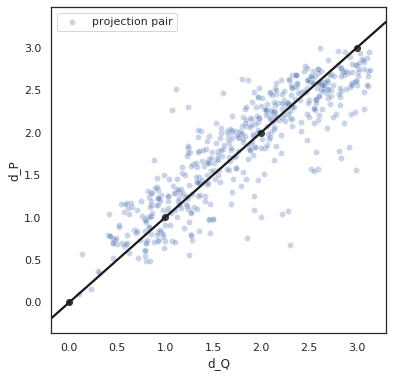

<Figure size 432x288 with 0 Axes>

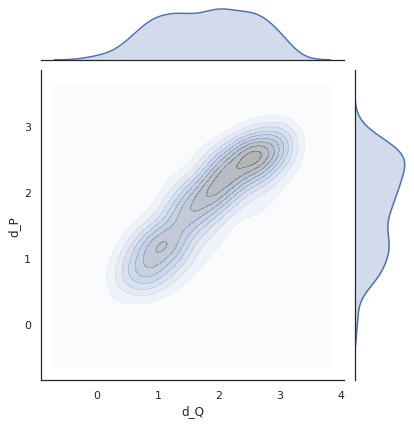

Variance = 0.35637769657573426
Min. angle recovery loss possible = 0.12675700585370303


In [23]:
# dP/dQ ratio plot
batch_size = 512
idx1 = list(np.random.choice(range(100), size=batch_size))
idx2 = list(np.random.choice(range(100), size=batch_size))

q1_true = euler2quaternion([angles_true_train[i] for i in idx1])
q2_true = euler2quaternion([angles_true_train[i] for i in idx2])

p1 = [projections_train[i] for i in idx1]
p2 = [projections_train[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

plot_dP_dQ(dP_values, dQ_values, f"{DE_LOGS_DIR}/dPdQ.png");

In [24]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

## (4) Projection Direction

In [25]:
############
#DE_LOGS_DIR = f"{RESULTS_DIR}/distance_estimation"
#DE_DESCRIPTION = "full_pipeline_5j0n"
DE_DIRECTION_DESCRIPTION = "full_pipeline_unseen_proteins_given_projDir_direction"

In [26]:
from cryoem.rotation_matrices import RotationMatrix

In [27]:
def RotationMatrixTF(angles):
    angles = tf.cast(angles, dtype=tf.float32)
    a1, a2, a3 = tf.unstack(angles, axis=1)
    
    # create rotation matrix
    c1 = tf.reshape(tf.cos(a1), (-1,1,1))
    c2 = tf.reshape(tf.cos(a2), (-1,1,1))
    c3 = tf.reshape(tf.cos(a3), (-1,1,1))

    s1 = tf.reshape(tf.sin(a1), (-1,1,1))
    s2 = tf.reshape(tf.sin(a2), (-1,1,1))
    s3 = tf.reshape(tf.sin(a3), (-1,1,1))
    
    # Euler angles
    # R = np.concatenate([np.concatenate([c3*c2*c1-s3*s1, c3*c2*s1 + s3*c1, -c3*s2],axis=2),\
    # 				np.concatenate([-s3*c2*c1-c3*s1,-s3*c2*s1+c3*c1 , s3*s2],axis=2),\
    # 				np.concatenate( [s2*c1,          s2*s1          , c2],axis=2)],axis=1)
    R = tf.concat([tf.concat([c1*c2*c3-s1*s3, c1*s3+c2*c3*s1 , -c3*s2],axis=2),\
                    tf.concat([-c3*s1-c1*c2*s3,    c1*c3-c2*s1*s3 ,   s2*s3],axis=2),\
                    tf.concat( [c1*s2,             s1*s2          ,   c2],axis=2)],axis=1)
    # BT angles
    # R = np.concatenate([np.concatenate([c1*c2, c2*s1, -s2],axis=2),\
    # 				np.concatenate([c1*s2*s3-c3*s1, c1*c3+s1*s2*s3, c2*s3],axis=2),\
    # 				np.concatenate( [s1*s3+c1*c3*s2, c3*s1*s2-c1*s3, c2*c3],axis=2)],axis=1)

    vec03 = tf.expand_dims(tf.transpose(tf.convert_to_tensor([0,0,1], dtype=tf.float32)), 1)
    vec36 = tf.expand_dims(tf.transpose(tf.convert_to_tensor([0,0,0], dtype=tf.float32)), 1)
    vec69 = tf.expand_dims(tf.transpose(tf.convert_to_tensor([1,0,0], dtype=tf.float32)), 1)
    vec912 = tf.expand_dims(tf.transpose(tf.convert_to_tensor([0,1,0], dtype=tf.float32)), 1)
    
    vec_all03 = tf.squeeze(tf.matmul(R, vec03))
    vec_all36 = tf.squeeze(tf.matmul(R, vec36))
    vec_all69 = tf.squeeze(tf.matmul(R, vec69))
    vec_all912 = tf.squeeze(tf.matmul(R, vec912))

    vectors = tf.concat([vec_all03, vec_all36, vec_all69, vec_all912], axis=1)

    return vectors

In [28]:
RotationMatrix(angles_true_test)[1:2], RotationMatrixTF(angles_true_test)[1:2]

(array([[ 0.57080078, -0.1607666 ,  0.8046875 ,  0.        ,  0.        ,
          0.        , -0.73144531, -0.54394531,  0.41040039,  0.37158203,
         -0.82324219, -0.4284668 ]]),
 <tf.Tensor: id=2641, shape=(1, 12), dtype=float32, numpy=
 array([[ 0.57117856, -0.16080147,  0.80492103,  0.        ,  0.        ,
          0.        , -0.7317607 , -0.54400945,  0.410585  ,  0.371862  ,
         -0.823527  , -0.4283947 ]], dtype=float32)>)

In [60]:
#from cryoem.rotation_matrices import RotationMatrix
from tensorflow_graphics.util import safe_ops, asserts, shape

def d_p_direction(angles1, angles2, dtype=tf.float64):
    """d = radius * atan2(norm(cross(P1,P2)),dot(P1,P2));"""
    angles1 = tf.cast(angles1, dtype=dtype)
    angles2 = tf.cast(angles2, dtype=dtype)
    #print("--- angles1: ", angles1)
    
    arr1 = RotationMatrixTF(angles1)[:,:3]
    arr2 = RotationMatrixTF(angles2)[:,:3]
    #print("--- arr: ", arr1)
    
    cross_product = tf.linalg.cross(arr1, arr2)
    #print("--- cross: ", cross_product)
    norm_cross_product = tf.linalg.norm(cross_product, axis=1)
    #print("--- norm: ", norm_cross_product)
    dot_product = tf.reduce_sum(arr1 * arr2, 1)
    
    
    result = tf.atan2(norm_cross_product, dot_product)
    
    # Ensure dot product is in range [-1. 1].
    #eps_dot_prod = 1.8 * asserts.select_eps_for_addition(dot_product.dtype)
    #dot_product = safe_ops.safe_shrink(dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)
    #print("---", tf.abs(dot_product))
    #result = tf.acos(tf.abs(dot_product)) 
    
    return tf.cast(result, dtype)

In [61]:
d_p_direction(angles_true_test, angles_true_test)#[:2], d_q(euler2quaternion(angles_true_test), euler2quaternion(angles_predicted))[:2]

<tf.Tensor: id=11651, shape=(1000,), dtype=float64, numpy=
array([1.18655343e-08, 2.98925174e-09, 7.95542832e-09, 1.34387852e-08,
       3.42616580e-09, 1.06126281e-08, 1.39233813e-09, 6.30929664e-09,
       1.40640442e-08, 4.29087921e-09, 4.19693347e-09, 1.25705810e-08,
       3.11646020e-09, 3.33908412e-09, 1.18185230e-08, 8.13484480e-09,
       2.26925945e-09, 1.99911065e-09, 1.07288658e-08, 1.26489557e-08,
       5.46210766e-09, 1.67122778e-08, 1.44267629e-08, 8.61287131e-09,
       1.35834632e-09, 1.18020038e-08, 1.85515603e-09, 1.13314957e-08,
       1.18271695e-08, 1.69961503e-08, 8.28989499e-09, 5.54429036e-09,
       1.09346727e-08, 3.34129124e-09, 3.07431680e-09, 3.30586158e-09,
       1.99189447e-08, 1.20298136e-08, 7.06571424e-09, 1.43361323e-08,
       6.70979228e-09, 1.64234208e-08, 2.03195749e-09, 8.33979197e-09,
       1.47508423e-08, 1.51383581e-08, 3.75641918e-09, 1.35409444e-08,
       1.97058370e-09, 1.24381296e-08, 1.01136397e-08, 1.49413237e-09,
       1.22840076e

In [31]:

#import tensorflow_probability as tfp
import os
import h5py
from time import time, strftime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib

#from cryoem.rotation_matrices import RotationMatrix
from cryoem.conversions import euler2quaternion, d_q
from cryoem.knn import get_knn_projections

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.python.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout, Concatenate, Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model, multi_gpu_model
#from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.losses import KLD, MAE, MSE
from tensorflow.keras.utils import Sequence
import pandas as pd
import seaborn as sns
import io

num_dec = 1
num_bins = 32

class DataGenerator_ProjectionDirection(Sequence):
    
    def __init__(self, X, y, list_ids, limit_num_pairs=None, limit_style="random", batch_size=256, shuffle=True):
        start_time = time()
        if batch_size > limit_num_pairs:
            raise Exception("Please specify limit_num_pairs that is much higher than batch_size")
        self.X = X  
        self.y = y  
        self.limit_num_pairs = limit_num_pairs
        self.list_ids = list_ids
        self.batch_size = batch_size  
        # all the possible combinations of 2 image id pairs
        self.pair_ids = np.array(list(zip(*list(map(lambda x: x.flatten(), np.meshgrid(list_ids, list_ids))))))  # e.g. train_idx
        
        # Don't use all possible combination of pairs, limit them here
        if self.limit_num_pairs:
            limited_pair_indices = np.random.choice(np.arange(len(self.pair_ids)), size=self.limit_num_pairs)
            self.pair_ids = self.pair_ids[limited_pair_indices]
        
        if limit_style=="uniform":
            self.pair_ids = self._generate_uniform()
      
        self.shuffle = shuffle 
        self._on_epoch_start()
        print(f"Data created in {time()-start_time} sec")
        
        
    def _generate_uniform(self):
        if os.path.exists(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy"):
            return np.load(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy")
        else:
            bins = {}
            for i in np.arange(0.0, 3.14, step=0.1): # so we have 32 bins
                bins[np.around(i, num_dec)] = []


            for idx1, idx2 in self.pair_ids:
                label = d_p_direction(self.y[idx1], self.y[idx2])
                bins[np.around(label, num_dec)].append([idx1, idx2])

            min_bin_size = len(bins[min(bins.keys(), key=lambda x: len(bins[x]))])
            print("min=", min_bin_size)
            if min_bin_size == 0:
                raise Exception("It haven't yet managed to fill all the bins, please increase limit_num_pairs")


            # cut the top of histogram to make it uniform
            for i in np.arange(0.0, 3.14, step=0.1): # so we have 32 bins
                b = np.around(i, num_dec)
                bins[b] = np.take(bins[b], np.arange(min_bin_size), axis=0)  

            l = np.array(list(itertools.chain(*list(bins.values()))))
            np.save(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy", l)
            print("total number of data = ", 31*min_bin_size)
            return l
    
    def __len__(self):
        # Denotes the number of batches per epoch
        if len(self.pair_ids)%self.batch_size == 0:
            return len(self.pair_ids) // self.batch_size
        else:
            return len(self.pair_ids) // self.batch_size + 1
        
    def __getitem__(self, index):
        # Generate one batch of data
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of ids
        list_ids_batch = np.take(self.pair_ids, indices, axis=0)

        # Generate data
        idx1, idx2 = list_ids_batch[:,0], list_ids_batch[:,1]
        pairs = np.stack((self.X[idx1], self.X[idx2]), axis=1)  # shape: (len(idx1), 2, x.shape[1], x.shape[2], x.shape[3])
        labels = d_p_direction(self.y[idx1], self.y[idx2])  # shape: len(idx1)

        return (pairs[:, 0], pairs[:, 1]), labels 
        
    def _on_epoch_start(self):
        # Updates indices after each epoch
        self.indices = np.arange(len(self.pair_ids))
        if self.shuffle:
            np.random.shuffle(self.indices)

# _idx1 = list(np.random.choice(val_idx, size=1000))
# _idx2 = list(np.random.choice(val_idx, size=1000))

# q1_true = euler2quaternion([angles_true[i] for i in _idx1])
# q2_true = euler2quaternion([angles_true[i] for i in _idx2])

# p1 = [X[i] for i in _idx1]
# p2 = [X[i] for i in _idx2]

model2 = None

def cosine_distance(vests):
    x, y = vests
    xy_sum_square = K.sum(x * y, axis=1, keepdims=True) 
    xx_sum_square = K.sum(x * x, axis=1, keepdims=True)
    xx_sum_square = K.maximum(xx_sum_square,  1e-08) 
    yy_sum_square = K.sum(y * y, axis=1, keepdims=True)
    yy_sum_square = K.maximum(yy_sum_square, 1e-08) 
    
    cos_theta = tf.divide(xy_sum_square, K.sqrt(xx_sum_square)*K.sqrt(yy_sum_square))
    eps = K.epsilon()
    return 2*tf.acos(tf.clip_by_value(cos_theta, 0.0+eps, 1.0-eps)) 

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def mae(y_true, y_pred):
    return MAE(y_true, y_pred) 

def mse(y_true, y_pred):
    return MSE(y_true, y_pred) 


def create_siamese_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_x = Input(shape=input_shape)
    #print(input_shape)

    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    
    x = Conv2D(filters=32, kernel_size=[7, 7], activation='relu', padding='same', kernel_initializer='glorot_uniform')(input_x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(64, [5, 5], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = AvgPool2D(pool_size=[8, 8], padding='same')(x)

    x = tf.squeeze(x, axis=[1,2])
    
    return Model(input_x, x)


def train_distance_direction_estimation(X, y, train_idx, val_idx, epochs, batch_size, learning_rate, limit_style, path_logs_training, training_description="", training_steps=None, validation_steps=None, plot=True, gpus=None, file_name=None):
    
    
    def d_p_direction_learned(p1, p2):
        global model2
        p1 = tf.cast(p1, dtype=tf.float64)
        p2 = tf.cast(p2, dtype=tf.float64)
        return model2.predict([p1, p2], batch_size=256)

    def plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image

    def generate_dPdQ_plot(file_writer_plot, val_idx, y, X):
        """Source: https://www.tensorflow.org/tensorboard/image_summaries#logging_arbitrary_image_data"""

        _idx1 = list(np.random.choice(val_idx, size=1000))
        _idx2 = list(np.random.choice(val_idx, size=1000))

        q1_true = [y[i] for i in _idx1]
        q2_true = [y[i] for i in _idx2]

        p1 = [X[i] for i in _idx1]
        p2 = [X[i] for i in _idx2]

        def _inner_plot(epoch, logs):
            """Generate dP/dQ plot for tensorboard"""
            dP_values = d_p_direction_learned(p1, p2).T[0]
            dQ_values = d_p_direction(q1_true, q2_true).numpy()

            # Creating the dataframe for SNS plot
            data = {"d_p_direction" : dQ_values, "d_p_direction_learned" : dP_values }
            df1 = pd.DataFrame(data=data)

            fig, ax = plt.subplots(figsize=(6,6));
            sns.scatterplot(x="d_p_direction", y="d_p_direction_learned", data=df1, color="b", alpha=0.3, label="projection pair", ax=ax);  # "reg", "kde"
            x = np.arange(0, np.pi);
            sns.regplot(x=x, y=x, color="k", ax=ax)
            #g = sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde");  # "reg", "kde"
            #plt.show()
            
            # Log the confusion matrix as an image summary.
            with file_writer_plot.as_default():
                tf.summary.image("dP/dQ plot", plot_to_image(fig), step=epoch)
        
        return _inner_plot

    mirrored_strategy = tf.distribute.MirroredStrategy()
    
    with mirrored_strategy.scope():
        # Prepare data generators
        training_generator   = DataGenerator_ProjectionDirection(X, y, train_idx, limit_num_pairs=training_steps, limit_style=limit_style, shuffle=True)
        validation_generator = DataGenerator_ProjectionDirection(X, y, val_idx, limit_num_pairs=validation_steps, limit_style=limit_style, shuffle=True)
        
        input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
        print(f"Input images shape {input_shape}")

        # network definition
        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)
        cnn_network = create_siamese_network(input_shape)
        
        # because we re-use the same instance `cnn_network`,
        # the weights of the network will be shared across the two branches
        processed_a = cnn_network(input_a)
        processed_b = cnn_network(input_b)

        
        distance = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([processed_a, processed_b])

        global model2
        model2 = Model([input_a, input_b], distance)  # was m

        # train
        #model = multi_gpu_model(m, gpus=gpus)
        model2.summary()
        #plot_model(model, to_file="figures/model_plot.png", expand_nested=True, show_shapes=True, show_layer_names=True)

        # training only top layers
        optimizer1 = RMSprop(learning_rate=learning_rate)
        model2.compile(loss=mae, optimizer=optimizer1, metrics=[mse], sample_weight_mode=None)

        # Setup callbacks
        # Callback that saves the model2
        training_description = training_description or strftime('%Y%m%d_%H%M%S')
        CHECKPOINT_PATH = os.path.join(f"{path_logs_training}/training", f"{training_description}.h5")
        pathlib.Path(f"{path_logs_training}/training").mkdir(parents=True, exist_ok=True)
        backup_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        print(f"Model will be saved to: {CHECKPOINT_PATH}")
        # Callback that will show tensorboard data
        LOGS_PATH = os.path.join(f"{path_logs_training}/logs", f"{training_description}")
        pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
        logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1) #, profile_batch=300)#100000000)
        # Callback for the dP/dQ plot
        file_writer_plot = tf.summary.create_file_writer(os.path.join(LOGS_PATH, "image"))
        plot_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=generate_dPdQ_plot(file_writer_plot, val_idx, y, X))
        # Callback that will decrease LR if it gets plateau in val_loss
        #reduce_on_plateau_callback = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=20, min_lr=1e-4, verbose=1)



        history1 = model2.fit(training_generator, 
                            epochs=epochs,
                            validation_data=validation_generator, 
                            callbacks=[plot_callback, logs_callback, backup_callback])
        
        # Get training and test loss histories
        training_loss = history1.history['loss']
        val_loss = history1.history['val_loss']
        mses = history1.history['mse']
        val_mses = history1.history['val_mse']
        pathlib.Path(f"{path_logs_training}/losses").mkdir(parents=True, exist_ok=True)
        np.savez(f"{path_logs_training}/losses/losses.npz", training_loss, val_loss, mses, val_mses)

        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

            # Create count of the number of epochs
            epoch_count = range(1, len(training_loss) + 1)

            # Visualize loss history
            ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
            ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
            ax1.legend()
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')

            ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
            ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
            ax2.legend()
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            
            if file_name:
                plt.savefig(file_name)

            plt.show();

        return model2, history1

def plot_results(projections, y_pred, y, strtype):
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(projections[i, 0])
        ax2.imshow(projections[i, 1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

Data created in 3.952702283859253 sec
Data created in 1.109665870666504 sec
Input images shape (64, 64, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
____________________________________________________________________________________

Epoch 39/100
27/27 [==============================] - 24s 876ms/step - loss: 0.1114 - mse: 0.0232 - val_loss: 0.2435 - val_mse: 0.1120
Epoch 40/100
27/27 [==============================] - 23s 858ms/step - loss: 0.1100 - mse: 0.0226 - val_loss: 0.2377 - val_mse: 0.1067
Epoch 41/100
27/27 [==============================] - 24s 881ms/step - loss: 0.1072 - mse: 0.0218 - val_loss: 0.2451 - val_mse: 0.1110
Epoch 42/100
27/27 [==============================] - 25s 919ms/step - loss: 0.1024 - mse: 0.0195 - val_loss: 0.2377 - val_mse: 0.1064
Epoch 43/100
27/27 [==============================] - 24s 903ms/step - loss: 0.1011 - mse: 0.0191 - val_loss: 0.2369 - val_mse: 0.1071
Epoch 44/100
27/27 [==============================] - 23s 868ms/step - loss: 0.0984 - mse: 0.0179 - val_loss: 0.2444 - val_mse: 0.1126
Epoch 45/100
27/27 [==============================] - 21s 778ms/step - loss: 0.0958 - mse: 0.0170 - val_loss: 0.2563 - val_mse: 0.1186
Epoch 46/100
27/27 [==============================] - 2

Epoch 100/100
27/27 [==============================] - 22s 805ms/step - loss: 0.0473 - mse: 0.0037 - val_loss: 0.1928 - val_mse: 0.0760


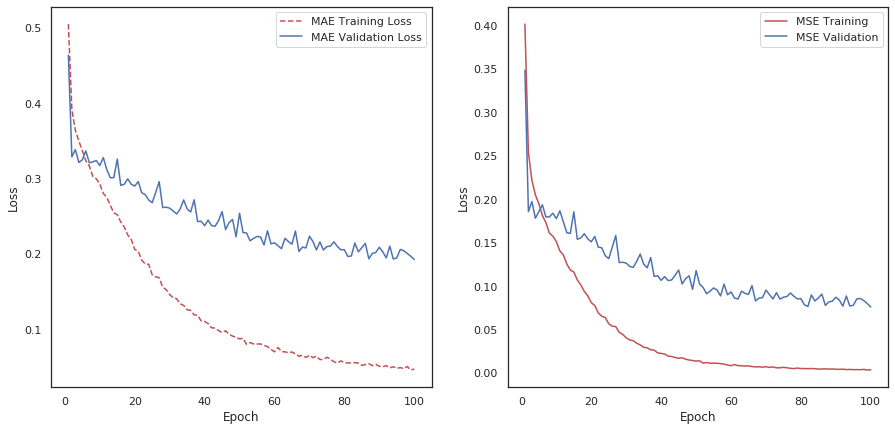

In [24]:
model_direction, history_direction = train_distance_direction_estimation(X=projections_train, y=angles_true_train, 
                                           train_idx=train_idx, 
                                           val_idx=val_idx,
                                           epochs=100,
                                           batch_size=256,  #512 latest 
                                           learning_rate=1e-3, 
                                           limit_style="random", 
                                           path_logs_training=DE_LOGS_DIR, 
                                           training_description=DE_DIRECTION_DESCRIPTION,
                                           training_steps=train_pairs_num,
                                           validation_steps=val_pairs_num, 
                                           plot=True,
                                           gpus=None)

In [32]:
# read stored model
model_filename = f"{DE_LOGS_DIR}/training/{DE_DIRECTION_DESCRIPTION}.h5"

# Recreate the exact same model, including its weights and the optimizer
model_direction = tf.keras.models.load_model(model_filename)

# Show the model architecture
model_direction.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [50]:
# learned distance function
def d_p_direction_learned(p1, p2, dtype=tf.float64):
    p1 = tf.cast(p1, dtype=dtype)
    p2 = tf.cast(p2, dtype=dtype)
    return tf.cast(model_direction.predict([p1, p2], batch_size=128), dtype=dtype)

<Figure size 432x288 with 0 Axes>

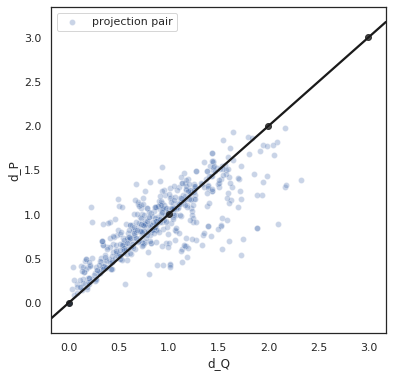

<Figure size 432x288 with 0 Axes>

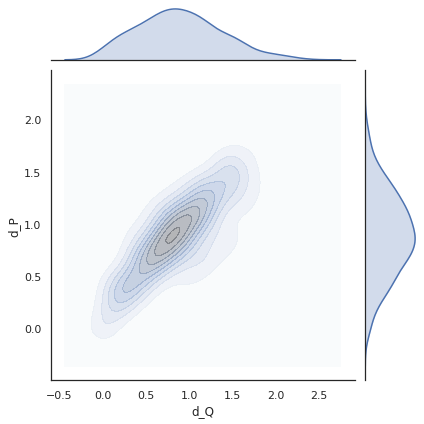

Variance = 0.27919292223792214
Min. angle recovery loss possible = 0.07779644429683685


In [34]:
# dP/dQ ratio plot
batch_size = 512
idx1 = list(np.random.choice(range(100), size=batch_size))
idx2 = list(np.random.choice(range(100), size=batch_size))

q1_true = [angles_true_train[i] for i in idx1]
q2_true = [angles_true_train[i] for i in idx2]

p1 = [projections_train[i] for i in idx1]
p2 = [projections_train[i] for i in idx2]

dP_values = d_p_direction_learned(p1, p2).T[0]
dQ_values = d_p_direction(q1_true, q2_true).numpy()

plot_dP_dQ(dP_values, dQ_values, f"{DE_LOGS_DIR}/dP_direction_learned.png");

In [63]:
tf.reduce_sum(d_q(euler2quaternion(angles_true_test),euler2quaternion(angles_true_test), dtype=tf.float32)) 

<tf.Tensor: id=12319, shape=(), dtype=float32, numpy=1.9390068>

In [64]:
tf.reduce_sum(d_q(euler2quaternion(angles_true_test),euler2quaternion(angles_true_test), dtype=tf.float64)) 

<tf.Tensor: id=12558, shape=(), dtype=float64, numpy=7.919365473611843e-05>

In [65]:
tf.reduce_sum(d_p_direction(angles_true_test, angles_true_test))

<tf.Tensor: id=12747, shape=(), dtype=float64, numpy=8.401856549432839e-06>

In [62]:
tf.reduce_sum(d_q(euler2quaternion(angles_true_test),euler2quaternion(angles_true_test), dtype=tf.float64)) + tf.reduce_sum(d_p_direction(angles_true_test, angles_true_test))

<tf.Tensor: id=12080, shape=(), dtype=float64, numpy=8.759551128555127e-05>

## (5) Angle Recovery

In [68]:
from cryoem.angle_recovery import train_angle_recovery

In [69]:
AR_LOGS_DIR = f"{RESULTS_DIR}/angle_recovery"
#AR_TRAINING_DESCRIPTION = "full_pipeline_5j0n"
AR_TRAINING_DESCRIPTION = "full_pipeline_unseen_proteins_projDir" #_ALL"

In [70]:
projections_test.shape

(1000, 64, 64, 1)

In [71]:
# QUATERNION VARIABLE
import time
import numpy as np
from IPython import display as IPyDisplay
from tensorflow.keras.optimizers import Adam
import seaborn as sns; sns.set(style="white", color_codes=True)
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import euler2quaternion, d_q, quaternion2euler
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from pathlib import Path

# TODO: add constraint on quaternion Variables


def angles_transpose(angles):
    angles = angles.copy()
    cols = [2, 1, 0]
    idx = np.empty_like(cols)
    idx[cols] = np.arange(len(cols))
    angles[:] = -angles[:, idx]
    return angles

def quaternion_constraint(low_ang, high_ang):
    
    def _inner(q):
        e = quaternion2euler(q)

        a0, a1, a2 = tf.unstack(e, axis=-1)
        a0 = tf.clip_by_value(a0, low_ang[0], high_ang[0])
        a1 = tf.clip_by_value(a1, low_ang[1], high_ang[1])
        a2 = tf.clip_by_value(a2, low_ang[2], high_ang[2])

        e_new = tf.stack((a0, a1, a2), axis=-1)
        q_new = euler2quaternion(e_new)
        return q_new

    return _inner
    


def train_angle_recovery_2(steps, 
                         batch_size, 
                         in_data, 
                         distance_fn, 
                         dustance_direction_fn,
                         file_name,
                         limit_distance=np.pi,
                         low_ang_const=[0.0, 0.0, 0.0],
                         high_ang_const=[2.0, 0.4, 2.0],
                         q_predicted=None,
                         angles_true=None,
                         learning_rate=0.01,
                         constraint=False): 

    time_start = time.time()
    collect_data = []
    optimizer = Adam(learning_rate=learning_rate)

    #low_ang = [0.0*np.pi, 0.0*np.pi, 0.0*np.pi]
    low_ang = list(map(lambda x: x*np.pi, low_ang_const))
    #high_ang = [2.0*np.pi, 0.4*np.pi, 2.0*np.pi] 
    high_ang = list(map(lambda x: x*np.pi, high_ang_const))           
    euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(in_data), 3))
    if q_predicted:
        # continue where left off
        if constraint:
            q_predicted = [tf.Variable(q, constraint=quaternion_constraint(low_ang, high_ang)) for q in q_predicted]
        else:
            q_predicted = [tf.Variable(q) for q in q_predicted]
    else:
        # optimize from scratch
        if constraint:
            q_predicted = [tf.Variable(q, constraint=quaternion_constraint(low_ang, high_ang)) for q in euler2quaternion(euler)]
        else:
            q_predicted = [tf.Variable(q) for q in euler2quaternion(euler)]

    if in_data.shape[1] == 3:
        in_data = euler2quaternion(in_data)

    losses = np.empty(steps)
    report = f"Shape of projections: {in_data.shape}"
    found_minimizer = False

    print(time.time()-time_start)

    for step, idx1, idx2 in sample_iter(steps, range(len(in_data)), batch_size, style="random"):
        q1 = [q_predicted[i] for i in idx1]
        q2 = [q_predicted[i] for i in idx2]
        #q1 = np.array(q1)
        #q2 = np.array(q2)

        # Compute distances
        in1 = [in_data[i] for i in idx1]
        in2 = [in_data[i] for i in idx2]
        #in1 = np.array(in1)
        #in2 = np.array(in2)

        distance_target = distance_fn(in1, in2)
        distance_direction_target = dustance_direction_fn(in1, in2)

        # WORK ONLY WITH LIMITED DISTANCES 
#         indices_le2 = np.where(distance_target<limit_distance)[0]
#         distance_target = np.take(distance_target, indices_le2)
#         q1 = list(np.take(q1, indices_le2))
#         q2 = list(np.take(q2, indices_le2))
#         in1 = list(np.take(in1, indices_le2))
#         in2 = list(np.take(in2, indices_le2))

        # Optimize by gradient descent.
        #print(type(distance_target[0][0]))
        #print(type(distance_direction_target[0][0]))
        losses[step-1], gradients = gradient(q1, q2, distance_target, distance_direction_target)
        optimizer.apply_gradients(zip(gradients, q1 + q2))

        # Visualize progress periodically
        if step % 10 == 0:
            a = np.zeros((len(q_predicted), 4))
            for i, e in enumerate(q_predicted):
                a[i] = e.numpy()
            collect_data.append(a)

            plt.close();
            sns.set(style="white", color_codes=True)
            sns.set(style="whitegrid")

            if angles_true is not None:
                fig, axs = plt.subplots(1, 3, figsize=(24,7))

                # Optimization loss subplot
                axs[0].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                axs[0].set_xlabel('time [s]')
                axs[0].set_ylabel('loss');
                axs[0].set_title(f"[{step}/{steps}] Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

                # NT - Distance count subplot (full)
                d2 = d_q(R.from_euler('zyz', angles_true).as_quat(), q_predicted)
                axs[1].set_xlim(0, np.pi)
                axs[1].set_title(f"[{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                s = sns.distplot(d2, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
                max_count = int(max([h.get_height() for h in s.patches]))
                axs[1].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

                # T - Distance count subplot (full)
                angles_true_T = angles_transpose(angles_true)
                d2 = d_q(R.from_euler('zyz', angles_true_T).as_quat(), q_predicted)
                axs[2].set_xlim(0, np.pi)
                axs[2].set_title(f"[{step}/{steps}] TRANSPOSED Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
                max_count = int(max([h.get_height() for h in s.patches]))
                axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
            else:
                fig, axs = plt.subplots(figsize=(10,7))

                # Optimization loss subplot
                axs.plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                axs.set_xlabel('time [s]')
                axs.set_ylabel('loss');
                axs.set_title(f"[{step}/{steps}] Angle recovery optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")


            IPyDisplay.clear_output(wait=True)
            IPyDisplay.display(plt.gcf())
            plt.close();
            time.sleep(0.1)

            Path(file_name).mkdir(parents=True, exist_ok=True)
            np.savez(file_name, quaternion.normalize(q_predicted).numpy(), losses, np.array(collect_data))

            if found_minimizer:
                time_elapsed = time.time() - time_start
                report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'
                break;

        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'

        if step >= 1001 and np.mean(losses[step-1001:step-1]) < 1e-8:
            found_minimizer = True

        if step >= 2001 and np.abs(np.mean(losses[step-1000:step-1])-np.mean(losses[step-2000:step-1000])) < 1e-7:
            found_minimizer = True

    print(report)
    return quaternion.normalize(q_predicted).numpy(), losses, np.array(collect_data)

def sample_iter(steps, projection_idx, num_pairs, style="random", k=None):

    for step in range(1, steps+1):
        if not k and style != "random":
            raise ValueError("Please specify k for kNN for sample_pairs method")

        if style=="random":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            idx2 = list(np.random.choice(projection_idx, size=num_pairs))

        elif style=="knn":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]

        elif style=="knn_and_random":
            # select random sample for the first element of pair
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))

            # half from kNN
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
            idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
            # half random
            idx2 = idx2_knn + idx2_random

        yield step, idx1, idx2

def loss(q1_predicted, q2_predicted, distance_target, distance_direction_target):
    # The mean doesn't depend on the batch size.
    #print("$$")
    #print((tf.reduce_mean(tf.pow(d_q(q1_predicted, q2_predicted, dtype=tf.float32) - distance_target, 2))))
    #print((tf.reduce_mean(tf.pow(d_p_direction(quaternion2euler(q1_predicted), quaternion2euler(q2_predicted)) - distance_direction_target, 2))))
    #print("*")
    #print(distance_direction_target) #- distance_direction_target, 2))
    #print(d_p_direction(quaternion2euler(q1_predicted), quaternion2euler(q2_predicted)))
    
    #print("--- quaternion1: ", q1_predicted)
    return tf.reduce_mean(tf.pow(d_q(q1_predicted, q2_predicted, dtype=tf.float64) - distance_target, 2)) + \
           tf.reduce_mean(tf.pow(d_p_direction(quaternion2euler(q1_predicted), quaternion2euler(q2_predicted)) - distance_direction_target, 2))

def gradient(q1_predicted, q2_predicted, distance_target, distance_direction_target):
    with tf.GradientTape() as tape:
        loss_value = loss(q1_predicted, q2_predicted, distance_target, distance_direction_target)
    gradient = tape.gradient(loss_value, q1_predicted + q2_predicted)

    return loss_value, gradient



In [72]:
#with learning rate 20, has S shape
# now lr 5

In [73]:
# import numpy as np
# import tensorflow as tf
# from tensorflow_graphics.util import safe_ops, asserts, shape
# from tensorflow_graphics.math import vector
# from tensorflow_graphics.geometry.transformation import quaternion, euler
# import math

# def quaternion2euler(quaternions):
#     """https://github.com/tensorflow/graphics/blob/master/tensorflow_graphics/geometry/transformation/euler.py"""
    
#     def general_case(r02, r12, r20, r21, r22, eps_addition):
#         """Handles the general case."""
#         theta_y = tf.acos(r22)
#         #sign_sin_theta_y = safe_ops.nonzero_sign(tf.sin(theta_y))
        
#         r02 = safe_ops.nonzero_sign(r02) * eps_addition + r02
#         r22 = safe_ops.nonzero_sign(r22) * eps_addition + r22
        
#         theta_z0 = tf.atan2(r12, r02)
#         theta_z1 = tf.atan2(r21, -r20)
#         return tf.stack((theta_z1, theta_y, theta_z0), axis=-1)

#     def gimbal_lock(r22, r11, r10, eps_addition):
#         """Handles Gimbal locks.
#         It is gimbal when r22 is -1 or 1"""
#         sign_r22 = safe_ops.nonzero_sign(r22)
#         r11 = safe_ops.nonzero_sign(r11) * eps_addition + r11
        
#         theta_z0 = tf.atan2(sign_r22 * r10, r11)
        
#         theta_y = tf.constant(math.pi/2.0, dtype=r20.dtype) - sign_r22 * tf.constant(math.pi/2.0, dtype=r20.dtype)
#         theta_z1 = tf.zeros_like(theta_z0)
#         angles = tf.stack((theta_z1, theta_y, theta_z0), axis=-1)
#         return angles

#     with tf.compat.v1.name_scope(None, "euler_from_quaternion", [quaternions]):
#         quaternions = quaternion.normalize(quaternions)

#         quaternions = tf.convert_to_tensor(value=quaternions)

#         shape.check_static(
#             tensor=quaternions,
#             tensor_name="quaternions",
#             has_dim_equals=(-1, 4))

#         x, y, z, w = tf.unstack(quaternions, axis=-1)
#         tx = safe_ops.safe_shrink(2.0 * x, -2.0, 2.0, True)
#         ty = safe_ops.safe_shrink(2.0 * y, -2.0, 2.0, True)
#         tz = safe_ops.safe_shrink(2.0 * z, -2.0, 2.0, True)
#         twx = tx * w
#         twy = ty * w
#         twz = tz * w
#         txx = tx * x
#         txy = ty * x
#         txz = tz * x
#         tyy = ty * y
#         tyz = tz * y
#         tzz = tz * z

#         # The following is clipped due to numerical instabilities that can take some
#         # enties outside the [-1;1] range.
        
#         r00 = safe_ops.safe_shrink(1.0 - (tyy + tzz), -1.0, 1.0, True)
#         r01 = safe_ops.safe_shrink(txy - twz, -1.0, 1.0, True)
#         r02 = safe_ops.safe_shrink(txz + twy, -1.0, 1.0, True)

#         r10 = safe_ops.safe_shrink(txy + twz, -1.0, 1.0, True)
#         r11 = safe_ops.safe_shrink(1.0 - (txx + tzz), -1.0, 1.0, True)
#         r12 = safe_ops.safe_shrink(tyz - twx, -1.0, 1.0, True)

#         r20 = safe_ops.safe_shrink(txz - twy, -1.0, 1.0, True)
#         r21 = safe_ops.safe_shrink(tyz + twx, -1.0, 1.0, True)
#         r22 = safe_ops.safe_shrink(1.0 - (txx + tyy), -1.0, 1.0, True)
        
#         eps_addition = asserts.select_eps_for_addition(quaternions.dtype)
#         general_solution = general_case(r02, r12, r20, r21, r22, eps_addition)
#         gimbal_solution = gimbal_lock(r22, r11, r10, eps_addition)
        
#         # The general solution is unstable close to the Gimbal lock, and the gimbal
#         # solution is not toooff in these cases.
#         # Check if r22 is 1 or -1
#         is_gimbal = tf.less(tf.abs(tf.abs(r22) - 1.0), 1.0e-6)
#         gimbal_mask = tf.stack((is_gimbal, is_gimbal, is_gimbal), axis=-1)
        
#         return tf.compat.v1.where(gimbal_mask, gimbal_solution, general_solution)  

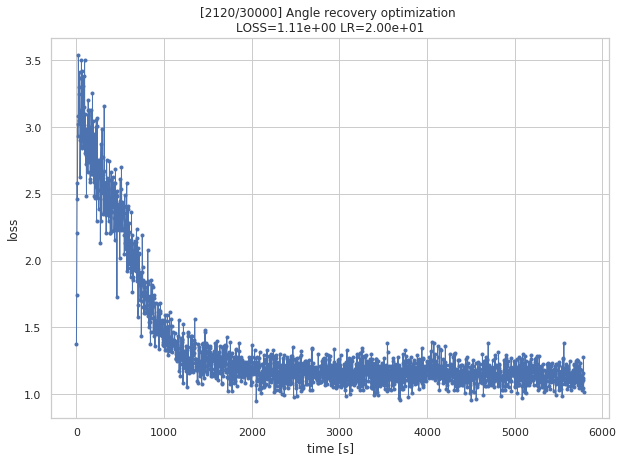

KeyboardInterrupt: 

In [74]:
# the 5j0n one 
q_predicted, losses, q_all = train_angle_recovery_2(steps=30000, 
                                                 batch_size=128, 
                                                 in_data=projections_test, 
                                                 distance_fn=d_p, 
                                                 dustance_direction_fn=d_p_direction_learned,
                                                 learning_rate=20, 
                                                 limit_distance=np.pi,
                                                 low_ang_const=ANGLE_SHIFT,
                                                 high_ang_const=[sum(x) for x in zip(ANGLE_SHIFT, ANGLE_COVERAGE)],
                                                 file_name=f"{AR_LOGS_DIR}/{AR_TRAINING_DESCRIPTION}",
                                                 constraint=False)

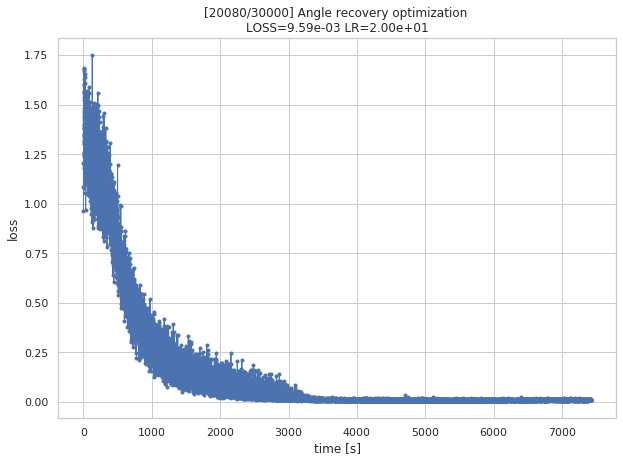

Shape of projections: (1000, 64, 64, 1)step 3000/30000 (638s): loss = 1.90e-01
step 6000/30000 (1302s): loss = 9.15e-02
step 9000/30000 (2050s): loss = 1.12e-02
step 12000/30000 (3263s): loss = 8.83e-03
step 15000/30000 (5057s): loss = 7.55e-03
step 18000/30000 (6431s): loss = 8.69e-03
step 20080/30000 (7420s): loss = 1.24e-02



In [35]:
q_predicted, losses, q_all = train_angle_recovery(steps=30000, 
                                                 batch_size=128, 
                                                 in_data=projections_test, 
                                                 distance_fn=d_p, 
                                                 learning_rate=20, 
                                                 limit_distance=np.pi,
                                                 low_ang_const=ANGLE_SHIFT,
                                                 high_ang_const=[sum(x) for x in zip(ANGLE_SHIFT, ANGLE_COVERAGE)],
                                                 file_name=f"{AR_LOGS_DIR}/{AR_TRAINING_DESCRIPTION}",
                                                 constraint=False)

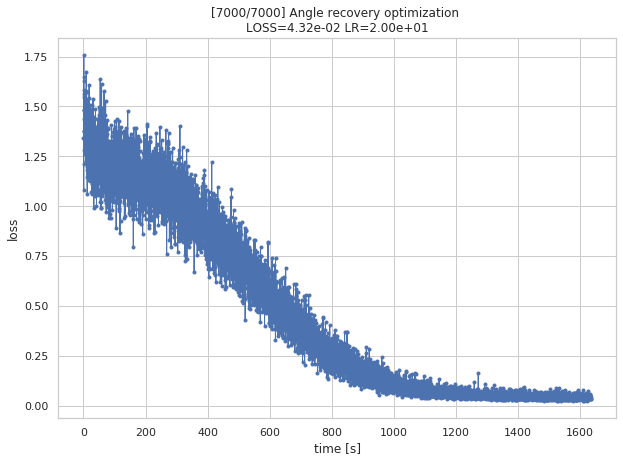

Shape of projections: (1000, 64, 64, 1)step 700/7000 (155s): loss = 9.57e-01
step 1400/7000 (305s): loss = 8.87e-01
step 2100/7000 (458s): loss = 6.71e-01
step 2800/7000 (611s): loss = 5.17e-01
step 3500/7000 (782s): loss = 3.49e-01
step 4200/7000 (937s): loss = 1.79e-01
step 4900/7000 (1093s): loss = 5.85e-02
step 5600/7000 (1310s): loss = 6.78e-02
step 6300/7000 (1471s): loss = 3.46e-02
step 7000/7000 (1635s): loss = 4.11e-02



In [73]:
q_predicted, losses, q_all = train_angle_recovery(steps=7000, 
                                                 batch_size=128, 
                                                 in_data=projections_test, 
                                                 distance_fn=d_p, 
                                                 learning_rate=20, 
                                                 limit_distance=np.pi,
                                                 low_ang_const=ANGLE_SHIFT,
                                                 high_ang_const=[2.0, 1.0, 2.0], #[sum(x) for x in zip(ANGLE_SHIFT, ANGLE_COVERAGE)],
                                                 file_name=f"{AR_LOGS_DIR}/{AR_TRAINING_DESCRIPTION}",
                                                 constraint=False)

In [102]:
#2.94e-01

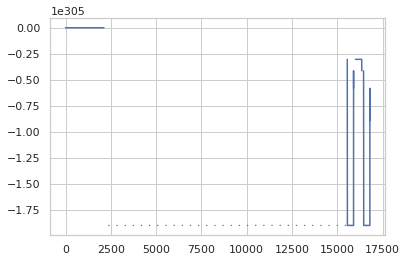

In [75]:
data = np.load(f"{AR_LOGS_DIR}/{AR_TRAINING_DESCRIPTION}.npz")
q_predicted, losses, collect_data = data['arr_0'], data['arr_1'], data['arr_2']
plt.plot(data["arr_1"][:20000])

In [39]:
angles_predicted = quaternion2euler(q_predicted)

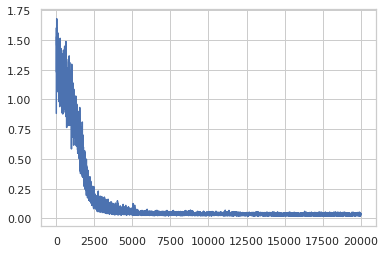

In [53]:
data = np.load(f"{AR_LOGS_DIR}/full_pipeline_unseen_proteins.npz")
q_predicted, losses, collect_data = data['arr_0'], data['arr_1'], data['arr_2']
plt.plot(data["arr_1"][:20000])

In [57]:
angles_predicted = quaternion2euler(q_predicted)

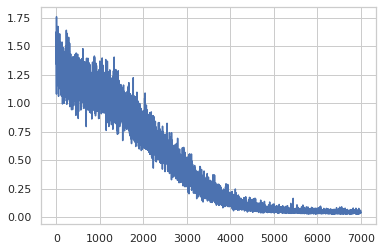

In [74]:
data = np.load(f"{AR_LOGS_DIR}/full_pipeline_unseen_proteins.npz")
q_predicted, losses, collect_data = data['arr_0'], data['arr_1'], data['arr_2']
plt.plot(data["arr_1"][:7000])

In [76]:
angles_predicted = quaternion2euler(q_predicted)

---

## (5) Angle Alignment

In [77]:
from cryoem.angle_alignment import training_angle_alignment

In [78]:
# angles_predicted = angles_predicted.numpy().astype(np.float16)

In [79]:
from tensorflow.keras.optimizers import Adagrad, Ftrl, Adam

m= [1.0, 1.0, 1.0, 1.0] 
trajectory_first= [3.10594002 4.53382079 0.79463155 6.25608888 0.41415731 0.7315097 ] 
loss_first= 2.3442226860519564 
trajectory_last= [ 1.02369979  3.1040193  -0.13358133  6.44582348 -0.0769818  -2.46112133] 
loss_last= 1.6781321437473624


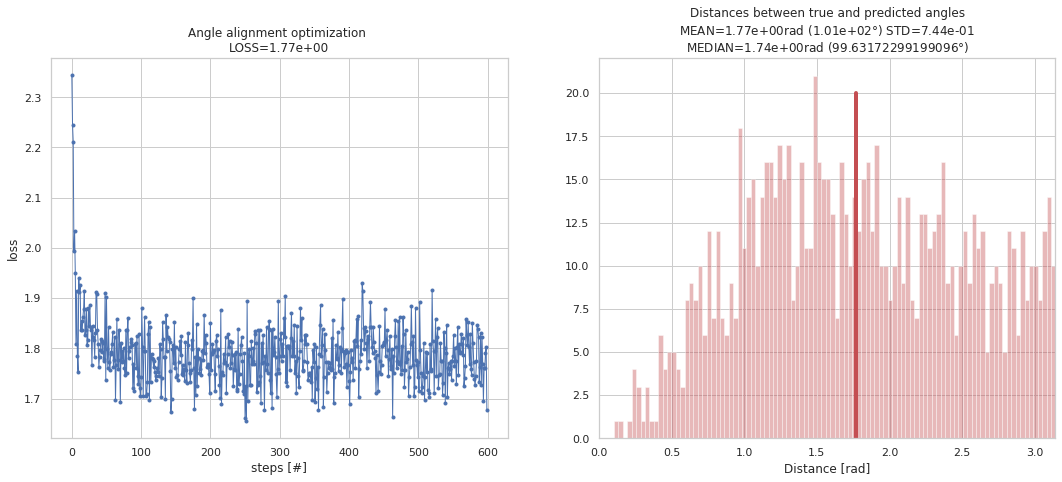

In [80]:
%matplotlib inline
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                                    steps=600, 
                                                                    batch_size=256, 
                                                                    optimizer=Adam(.2),#Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                                    angles_true=angles_true_test, 
                                                                    angles_predicted=angles_predicted,
                                                                    threshold=None,
                                                                    dtype=tf.float64)

m= [1.0, 1.0, 1.0, -1.0] 
trajectory_first= [0.66824932 5.17613368 2.66991423 2.94059185 0.25610893 4.55185738] 
loss_first= 2.155689077894699 
trajectory_last= [-1.49040001  4.88438257  2.80793722  0.44864749  0.11947278  6.01334627] 
loss_last= 0.18695579457551037


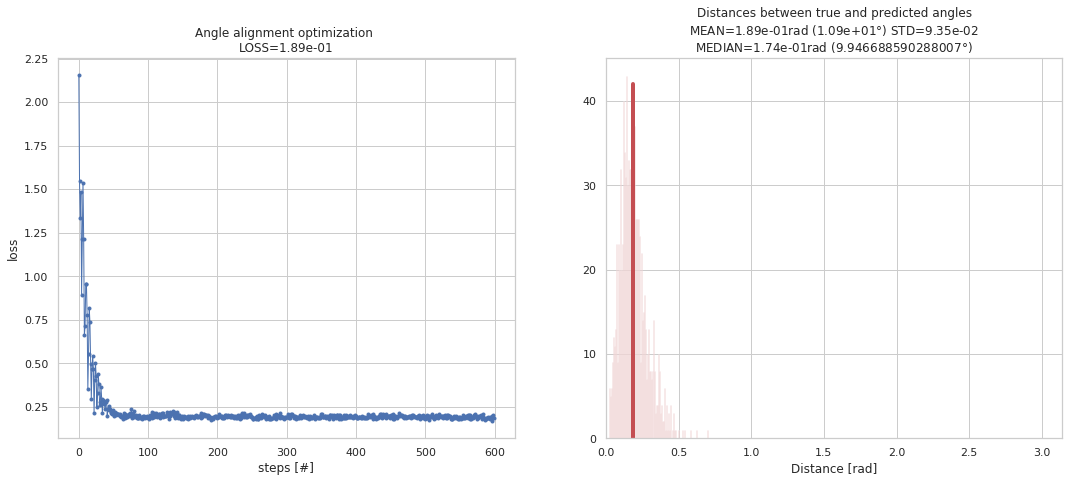

In [73]:
%matplotlib inline
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                                    steps=600, 
                                                                    batch_size=256, 
                                                                    optimizer=Adam(.2),#Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                                    angles_true=angles_true_test, 
                                                                    angles_predicted=angles_predicted,
                                                                    threshold=None,
                                                                    dtype=tf.float64)

In [52]:
from cryoem.plots import plot_iterations_rotvec

In [53]:
%matplotlib inline
plot_iterations_rotvec(collect_data, np.array(angles_true_test), interval=1000, connections=True, selected=range(1000))

In [43]:
angles_true_test

array([[3.082 , 0.909 , 1.357 ],
       [5.477 , 0.6353, 3.416 ],
       [0.5186, 0.758 , 1.049 ],
       ...,
       [2.85  , 0.8135, 4.766 ],
       [3.26  , 0.5674, 3.701 ],
       [4.992 , 1.016 , 1.939 ]], dtype=float16)

In [44]:
angles_predicted_rotated

array([[-2.20010175,  0.52838538,  1.07743457],
       [ 0.25983283,  1.79163116,  0.30951054],
       [ 1.0802668 ,  0.96421563,  0.02050268],
       ...,
       [ 0.87605412,  0.21407569,  0.20309698],
       [ 3.04621496,  0.63753716,  3.01857204],
       [ 1.20026597,  0.79377167,  0.21571847]])

In [38]:
ipv.screenshot()

Output()

In [55]:
from cryoem.plots import plot_iterations_polar_plot, plot_pixels_pairs

In [54]:
%matplotlib inline
plot_iterations_polar_plot(collect_data, np.array(angles_true_test), interval=1000, connections=True, selected=range(500))

In [58]:
plot_pixels_pairs(np.array(angles_true_test), angles_predicted, interval=1, connections=True, selected=range(100))

In [61]:
from scipy.spatial.transform import Rotation as R

In [63]:
from tensorflow_graphics.util import safe_ops, asserts, shape

def d_geo(m1, m2):
    m = tf.matmul(m1, tf.linalg.inv(m2))
    m = tf.reshape(m, shape=[-1, 3, 3])
    acos_in = (tf.linalg.trace(m)-1)/2
    
    # Ensure dot product is in range [-1. 1].
    eps_dot_prod = 1.8 * asserts.select_eps_for_addition(acos_in.dtype)
    acos_in = safe_ops.safe_shrink(acos_in, -1, 1, open_bounds=False, eps=eps_dot_prod)
    
    return tf.math.acos(acos_in)

def gGS(a):
    a1, a2, a3 = tf.unstack(a, axis=-1)
    return tf.stack((a1, a2), axis=-1)


def fGS(a):
    a1, a2 = tf.unstack(a, axis=-1)
    b1 = a1/tf.transpose(tf.broadcast_to(tf.linalg.norm(a1, axis=1), shape=[3, len(a)]))
    b2 = a2 - tf.transpose(tf.broadcast_to(tf.reduce_sum(b1 * a2, 1), shape=[3,len(a)])) * b1
    b2 = b2/tf.transpose(tf.broadcast_to(tf.linalg.norm(b2, axis=1), shape=[3, len(a)]))  #tf.linalg.norm(b2, axis=0)
    b3 = tf.linalg.cross(b1, b2)
    
    return tf.stack((b1,b2,b3), axis=-1)
    

In [68]:
M_euler = R.from_euler('zyz', angles_true_test).as_matrix()
ggs1 = fGS(gGS(M_euler))
angles_true_test_new = R.from_matrix(ggs1).as_euler('zyz')
print(angles_true_test)
angles_true_test_new

[[3.082  0.909  1.357 ]
 [5.477  0.6353 3.416 ]
 [0.5186 0.758  1.049 ]
 ...
 [2.85   0.8135 4.766 ]
 [3.26   0.5674 3.701 ]
 [4.992  1.016  1.939 ]]


array([[ 3.08203125,  0.90917969,  1.35742188],
       [-0.80662281,  0.63525391, -2.86716968],
       [ 0.51855469,  0.7578125 ,  1.04882812],
       ...,
       [ 2.84960938,  0.81347656, -1.51756031],
       [-3.02341968,  0.56738281, -2.58201343],
       [-1.29099781,  1.015625  ,  1.93945313]])

In [69]:
M_euler = R.from_euler('zyz', angles_predicted).as_matrix()
ggs1 = fGS(gGS(M_euler))
angles_predicted_new = R.from_matrix(ggs1).as_euler('zyz')
print(angles_predicted)
angles_predicted_new

tf.Tensor(
[[ 1.01087976  1.11410259  2.08242166]
 [-1.90211836  1.24466688 -1.33723364]
 [-1.9498653   1.232475   -0.18260631]
 ...
 [-2.63605393  1.29649805  0.41370519]
 [ 2.26941781  1.15270017  1.85659778]
 [-2.07744666  1.50366408 -0.00683118]], shape=(1000, 3), dtype=float64)


array([[ 1.01087976,  1.11410259,  2.08242166],
       [-1.90211836,  1.24466688, -1.33723364],
       [-1.9498653 ,  1.232475  , -0.18260631],
       ...,
       [-2.63605393,  1.29649805,  0.41370519],
       [ 2.26941781,  1.15270017,  1.85659778],
       [-2.07744666,  1.50366408, -0.00683118]])

m= [1.0, 1.0, 1.0, -1.0] 
trajectory_first= [0.4886323  0.96744325 4.29200532 2.83172699 1.92329541 0.38577142] 
loss_first= 1.9531604446573465 
trajectory_last= [-13.73326911  -1.67399402   6.09635417   7.76921772   3.2519325
   1.18755456] 
loss_last= 1.33340793940188


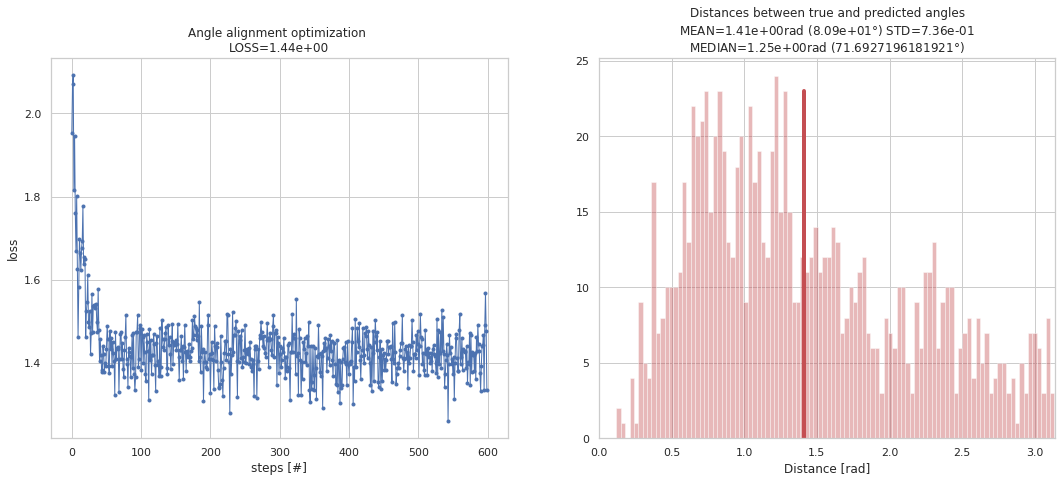

In [70]:
%matplotlib inline
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                                    steps=600, 
                                                                    batch_size=256, 
                                                                    optimizer=Adam(.2),#Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                                    angles_true=angles_true_test_new, 
                                                                    angles_predicted=angles_predicted_new,
                                                                    threshold=None,
                                                                    dtype=tf.float64)

In [75]:
np.array(angles_true_test_new).shape

(1000, 3)

In [107]:
r = np.pi
angles_true_test_new_ = np.empty(angles_true_test_new.shape)
for i, a in enumerate(np.array(angles_true_test_new)):
    rw = R.from_euler('zyz',a).as_rotvec()
    rw = [rw[0], np.cos(rw[2]), np.sin(rw[2])]
    angles_true_test_new_[i] = R.from_rotvec(rw).as_euler('zyz')

In [108]:

angles_predicted_new_ = np.empty(angles_predicted_new.shape)
for i, a in enumerate(np.array(angles_predicted_new)):
    rw = R.from_euler('zyz',a).as_rotvec()
    rw = [rw[0], np.pi*rw[1], np.pi*rw[2]]
    angles_predicted_new_[i] = R.from_rotvec(rw).as_euler('zyz')

In [103]:
%matplotlib inline
plot_iterations_rotvec(collect_data, np.array(angles_true_test_new_), interval=1000, connections=True, selected=range(1000))

m= [1.0, 1.0, 1.0, 1.0] 
trajectory_first= [1.36731362 2.98442222 5.3781394  4.04126449 5.49310104 3.52290646] 
loss_first= 2.1243475378829073 
trajectory_last= [-0.22314562  3.14819007  6.20906327  3.29243346  6.31732721  3.20496344] 
loss_last= 1.4300886111385867


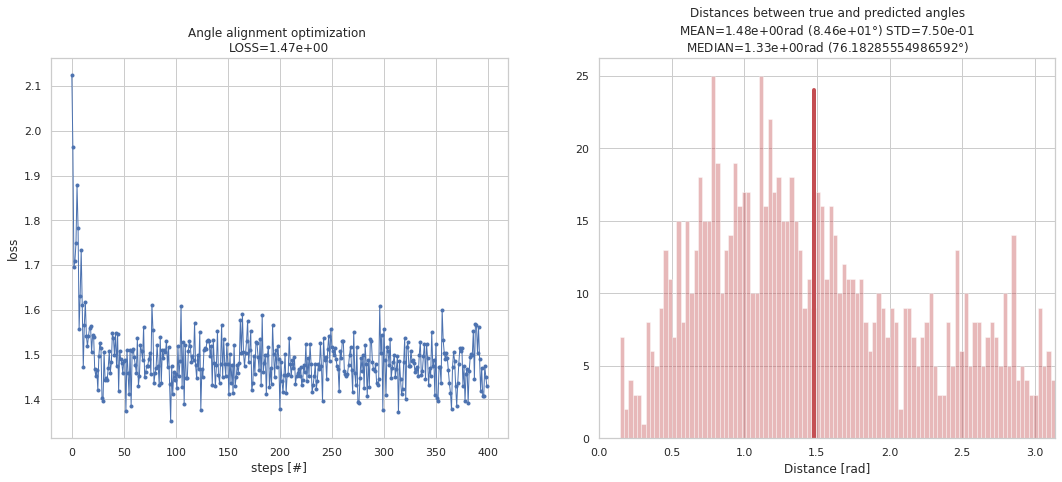

In [111]:
%matplotlib inline
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                                    steps=400, 
                                                                    batch_size=256, 
                                                                    optimizer=Adam(.2),#Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                                    angles_true=angles_true_test, 
                                                                    angles_predicted=angles_predicted_new_,
                                                                    threshold=None,
                                                                    dtype=tf.float64)

In [113]:
%matplotlib inline
plot_iterations_rotvec(collect_data, np.array(angles_true_test), interval=1000, connections=True, selected=range(1000))

In [96]:
%matplotlib inline
plot_iterations_rotvec(collect_data, np.array(angles_true_test_new_), interval=1000, connections=True, selected=range(1000))

In [27]:
q_predicted = euler2quaternion(angles_predicted)

In [28]:
q_predicted_rotated =  update_quaternion(m, a_R, q_predicted, dtype=tf.float64)
angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

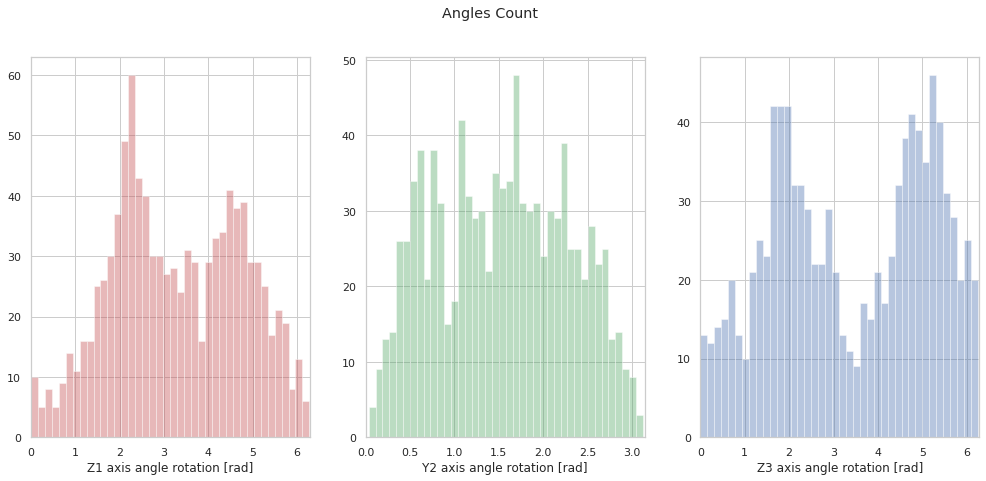

In [58]:
plot_angles_count(np.array(angles_predicted))

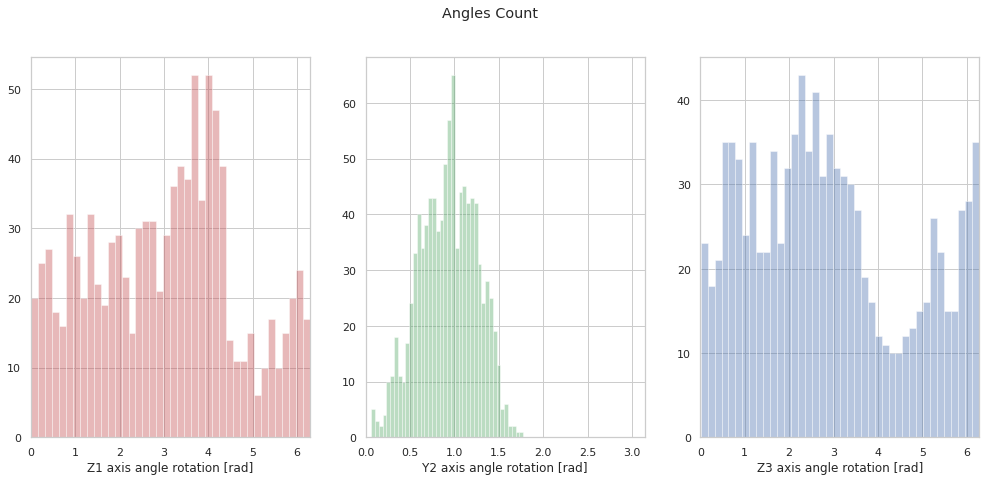

In [52]:
#bad
plot_angles_count(np.array(angles_predicted))

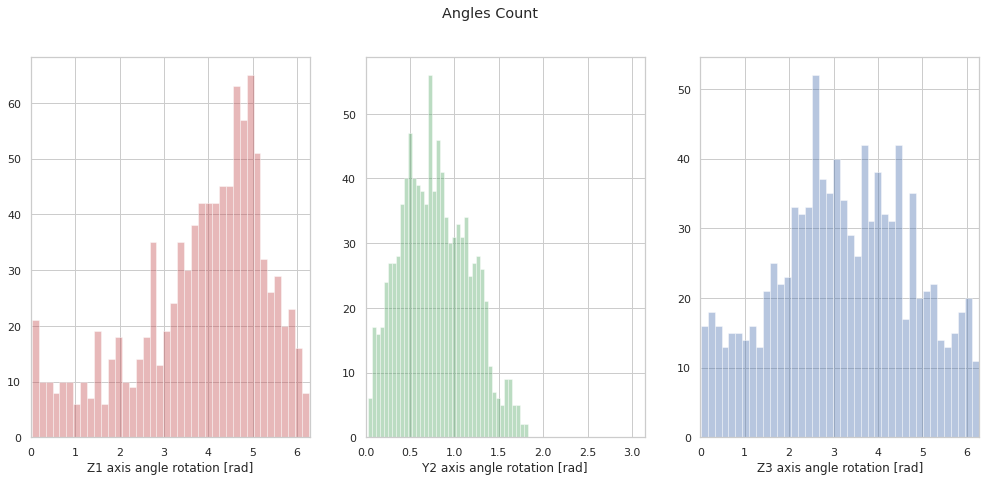

In [68]:
plot_angles_count(np.array(angles_predicted_rotated))

In [45]:
np.array(angles_predicted_rotated).shape

(1000, 3)

In [49]:
len(np.split(np.array(angles_predicted_rotated), 3, axis=1))

3

In [97]:
angles_predicted_rotated_unif.shape

(1000, 3)

In [33]:
def norm2unif(norm):
    z1, z2, z3 = np.split(np.array(norm), 3, axis=1)
    x1 = np.exp(-(z1**2+z2**2+z3**2)/2)
    x2 = np.arctan2(z2, z1)  # 1/(2*np.pi)*
    x3 = np.arctan2(np.sqrt(z1**2+z2**2), z3)  #np.arccos(z3, np.sqrt(z1**2+z2**2+z3**2)) #
    unif = np.stack([x1, x2, x3], axis=1)
    return np.squeeze(unif)

In [34]:
angles_predicted_rotated_unif = norm2unif(np.array(angles_predicted_rotated))

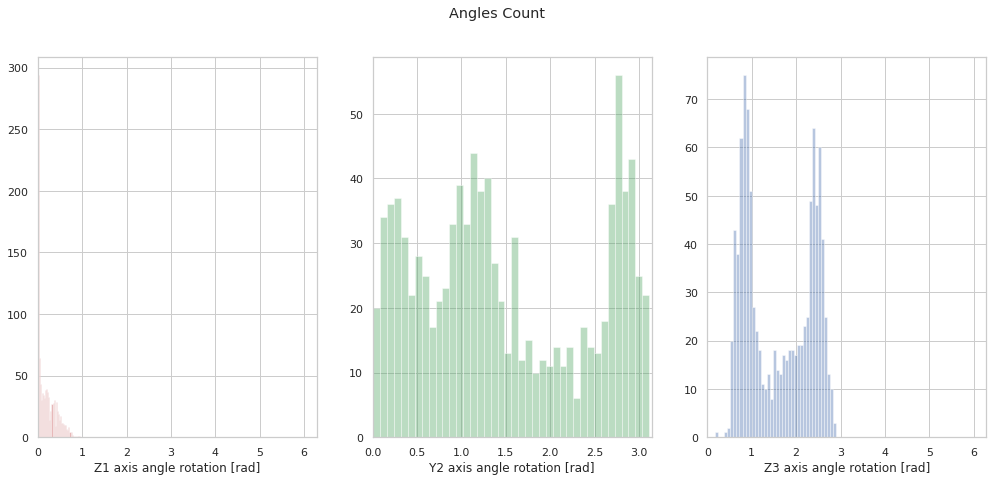

In [35]:
plot_angles_count(angles_predicted_rotated_unif)

In [86]:
plot_detector_pixels(angles_predicted_rotated_unif[:1000])

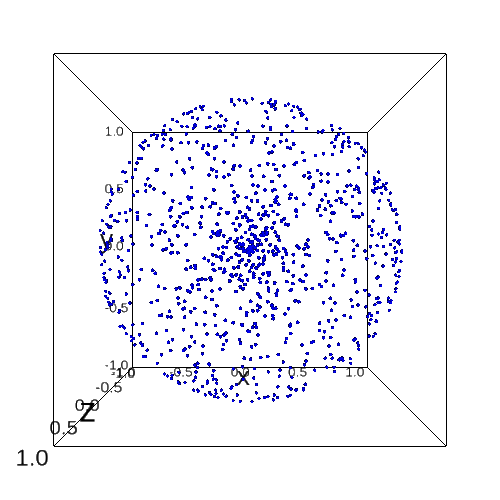

In [54]:
plot_detector_pixels(angles_true_test[:1000])

In [55]:
ipv.screenshot()

Output()

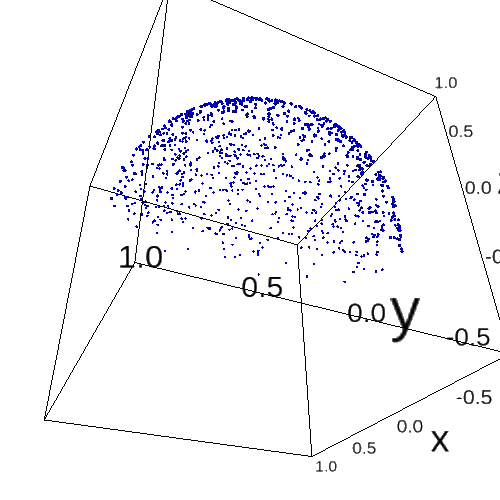

In [36]:
plot_detector_pixels(angles_predicted_rotated[:1000])

In [37]:
ipv.screenshot()

Output()

In [39]:
from cryoem.plots import plot_images

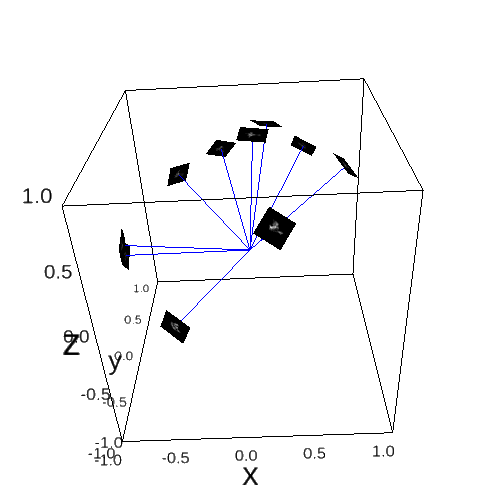

In [50]:
plot_images(angles_predicted_rotated, np.squeeze(projections), indices=range(10), img_size_scale=0.2)

In [51]:
ipv.screenshot()

Output()

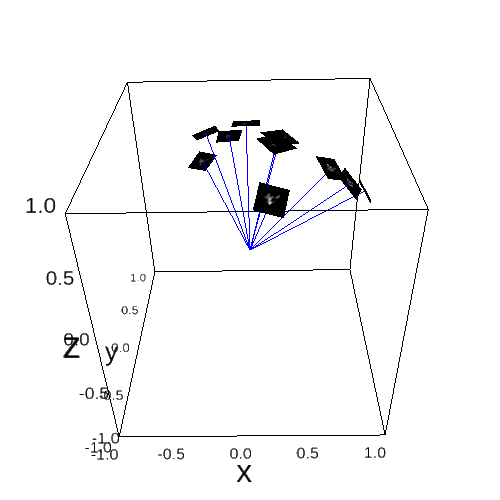

In [52]:
plot_images(angles_true, np.squeeze(projections), indices=range(10), img_size_scale=0.2)

In [53]:
ipv.screenshot()

Output()

In [58]:
angles_predicted_rotated[:10]

<tf.Tensor: id=22872924, shape=(10, 3), dtype=float64, numpy=
array([[ 1.19874664,  1.40521155, -1.70032457],
       [ 0.14810723,  1.17553374,  1.06462635],
       [ 1.55521255,  0.28366718,  0.14069029],
       [ 3.04469305,  1.21737728, -2.35914408],
       [ 0.01479672,  1.31838986, -0.14811443],
       [ 0.9900333 ,  1.11678738, -0.17265203],
       [ 2.44354383,  0.7713333 ,  3.13954236],
       [-2.92173393,  0.71920017, -2.26128806],
       [-3.09025003,  0.36610354, -1.3431956 ],
       [ 0.02569316,  0.62477705, -0.70530668]])>

In [59]:
angles_predicted_rotated[:10]%(2*np.pi)

<tf.Tensor: id=22872930, shape=(10, 3), dtype=float64, numpy=
array([[1.19874664, 1.40521155, 4.58286073],
       [0.14810723, 1.17553374, 1.06462635],
       [1.55521255, 0.28366718, 0.14069029],
       [3.04469305, 1.21737728, 3.92404123],
       [0.01479672, 1.31838986, 6.13507088],
       [0.9900333 , 1.11678738, 6.11053328],
       [2.44354383, 0.7713333 , 3.13954236],
       [3.36145138, 0.71920017, 4.02189724],
       [3.19293528, 0.36610354, 4.93998971],
       [0.02569316, 0.62477705, 5.57787863]])>

In [60]:
angles_true_test[:10]

array([[3.082 , 0.909 , 1.357 ],
       [5.477 , 0.6353, 3.416 ],
       [0.5186, 0.758 , 1.049 ],
       [3.955 , 1.125 , 2.957 ],
       [0.1964, 0.8184, 3.36  ],
       [5.78  , 1.22  , 1.118 ],
       [2.414 , 0.2263, 3.248 ],
       [4.8   , 0.2208, 1.515 ],
       [3.576 , 0.6274, 4.45  ],
       [0.4182, 0.2267, 3.65  ]], dtype=float16)

In [29]:
np.save(f"{RESULTS_DIR}/angle_recovery/angles_CIRCLE.npy", angles_predicted_rotated)

---

## (6) Reconstruction

In [30]:
angles_predicted_rotated = np.load(f"{RESULTS_DIR}/angle_recovery/angles_CIRCLE.npy")

In [27]:
angles_predicted = np.load(f"{RESULTS_DIR}/custom_true_angles.npy")

In [31]:
REC_LOGS_DIR = f"{RESULTS_DIR}/reconstruction"
REC_DESCRIPTION = "full_pipeline_test1.mrc"

In [32]:
# angles_predicted_rotated

In [33]:
# angles_true

In [34]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
from cryoem.rotation_matrices import RotationMatrix
import astra
import mrcfile
from pathlib import Path

def reconstruct(projections, angles, mrc_filename=None, overwrite=False):
    # Generate orientation vectors based on angles
    orientation_vectors   = RotationMatrix(angles)

    # Reshape projections correctly 
    projections1 = np.transpose(projections, (1, 0, 2))
    
    # Get projection dimension
    proj_size = projections1.shape[0]

    # Create projection 2D geometry in ASTRA
    proj_geom = astra.create_proj_geom('parallel3d_vec', proj_size, proj_size, orientation_vectors)
    #proj_geom = astra.create_proj_geom('parallel3d', 0.5, 0.5, proj_size, proj_size, orientation_vectors)
    projections_id = astra.data3d.create('-sino', proj_geom, projections1)

    # Create reconstruction.
    vol_geom = astra.creators.create_vol_geom(proj_size, proj_size, proj_size)
    reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
    alg_cfg = astra.astra_dict('BP3D_CUDA')
    alg_cfg['ProjectionDataId'] = projections_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data3d.get(reconstruction_id)


    # Limit and scale reconstruction.
    reconstruction[reconstruction < 0] = 0
    reconstruction /= np.max(reconstruction)
    reconstruction = np.round(reconstruction * 255).astype(np.uint8)

    # Cleanup.
    astra.algorithm.delete(algorithm_id)
    astra.data3d.delete(reconstruction_id)
    astra.data3d.delete(projections_id)


    # Save reconstruction to mrc file for chimera
    if mrc_filename:
        Path(mrc_filename).parent.mkdir(parents=True, exist_ok=True)
        with mrcfile.new(mrc_filename, overwrite=overwrite) as mrc:
            mrc.set_data(reconstruction)
        
    return reconstruction

def reconstruct_from_file(input_file, limit=3000, mrc_filename=None):
    data = np.load(f'data/{input_file}.npz')
    projections, angles = data["arr_0"].astype(np.float64)[:limit, :, :], data["arr_1"].astype(np.float64)[:limit, :]

    return reconstruct(projections, angles, mrc_filename)


In [19]:
projections_test_original = np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, IMG_DIM, IMG_DIM, CHANNELS), dtype=DTYPE)
angles_true_test = np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, 3), dtype=DTYPE)

print(f"\n* Test dataset *")
for i, protein in enumerate(PROTEINS_TEST):
    #data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
    data = h5py.File(f"{RESULTS_DIR}/{protein}_given.h5", 'r')
    
    projections = np.array(data['Projections'], dtype=np.float32)
    print(np.min(projections) - np.max(projections))
    if np.isnan(projections).any() or (np.min(projections) - np.max(projections) == 0): 
        PROTEINS_TEST.remove(protein)
        continue
    angles_true = np.array(data['Angles'], dtype=np.float32)
    if np.isnan(angles_true).any() or (np.min(angles_true) - np.max(angles_true) == 0): 
        PROTEINS_TEST.remove(protein)
        continue
    
    print(f"--- protein: {protein} ---")
    print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
    print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")
    
    projections = preprocessing(projections, rescale_dim=IMG_DIM, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=CHANNELS)
    
    projections_test_original[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = projections.astype(DTYPE)
    angles_true_test[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = angles_true.astype(DTYPE)


* Test dataset *
-40.0625
--- protein: 5j0n ---
1000 projections of images with dimension (218, 218) pixels
1000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images
Preprocessing projections
	Image rescaled: 
		from dimension 218 to 64
	Global standardization
		Image shape: (64, 64)
		Data Type: float64
		Mean: 0.790 | Std: 2.622
		Min:  0.000 | Max: 34.106
		Mean: -0.000 | Std: 1.000
		Min:  -0.301 | Max: 12.706
	Noise:
		No noise
	Translation:
		No translation


In [20]:
angles_predicted_rotated.shape

(1000, 3)

In [35]:
reconstruction_pred = reconstruct(np.squeeze(projections_test_original)[:1000], angles_true_test[:1000], mrc_filename='test_protein.mrc', overwrite=True)
reconstruction_pred = reconstruction_pred.astype(np.float)

NameError: name 'projections_test_original' is not defined

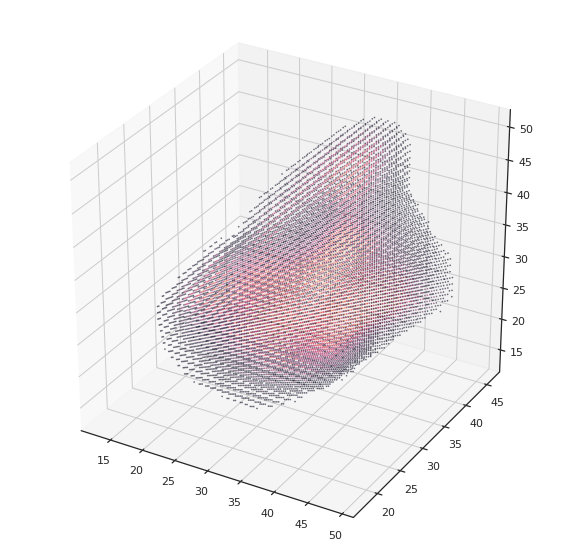

In [47]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 1

volume = reconstruction_pred 
volume[volume<40.] = np.nan

x = np.arange(volume.shape[0])[::step, None, None]
y = np.arange(volume.shape[1])[None, ::step, None]
z = np.arange(volume.shape[2])[None, None, ::step]
x, y, z = np.broadcast_arrays(x, y, z)
c = volume[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(), alpha=0.5, s=0.5,
           c=c)

In [48]:
angles_predicted_rotated.shape

(1000, 3)

In [42]:
reconstruction_pred = reconstruct(np.squeeze(projections)[:1000], angles_predicted_rotated[:1000], mrc_filename='test_protein2.mrc', overwrite=True)
reconstruction_pred = reconstruction_pred.astype(np.float)

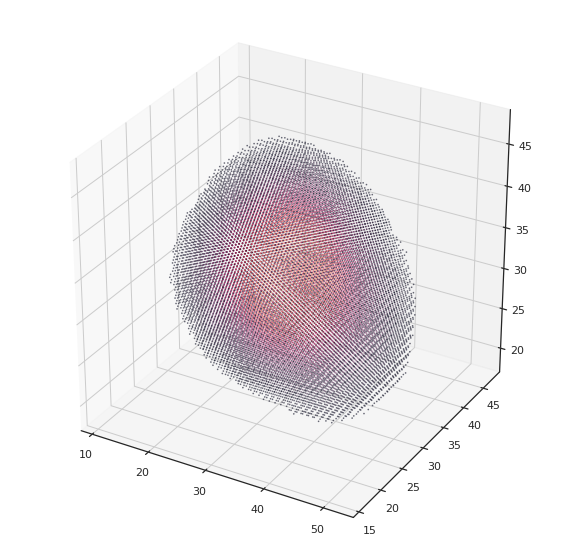

In [50]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 1

volume = reconstruction_pred 
volume[volume<40.] = np.nan

x = np.arange(volume.shape[0])[::step, None, None]
y = np.arange(volume.shape[1])[None, ::step, None]
z = np.arange(volume.shape[2])[None, None, ::step]
x, y, z = np.broadcast_arrays(x, y, z)
c = volume[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(), alpha=0.5, s=0.5,
           c=c)

In [51]:
angles_predicted.shape

(1000, 3)

In [52]:
reconstruction_pred = reconstruct(np.squeeze(projections_test_original)[:1000], angles_predicted[:1000], mrc_filename='test_protein3.mrc', overwrite=True)
reconstruction_pred = reconstruction_pred.astype(np.float)

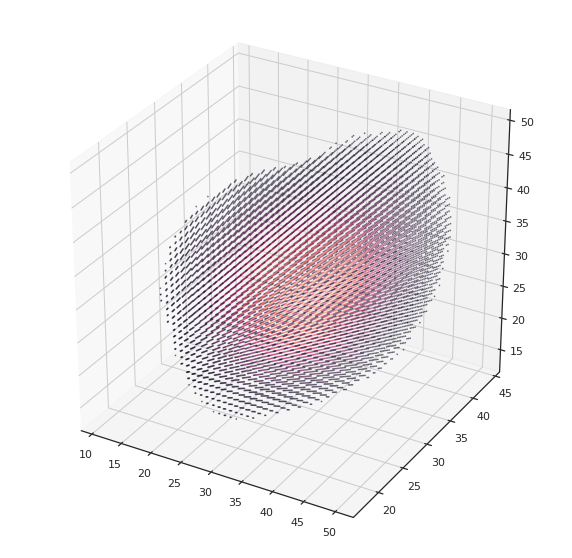

In [53]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 1

volume = reconstruction_pred 
volume[volume<40.] = np.nan

x = np.arange(volume.shape[0])[::step, None, None]
y = np.arange(volume.shape[1])[None, ::step, None]
z = np.arange(volume.shape[2])[None, None, ::step]
x, y, z = np.broadcast_arrays(x, y, z)
c = volume[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(), alpha=0.5, s=0.5,
           c=c)